In [26]:
from utils import base_configs, deps, tr_va_te_split
from utils.helpers import dir_helpers, rw_csv_helpers, feature_distr_helpers

In [27]:
from tqdm import TqdmWarning
import warnings
warnings.filterwarnings("ignore", category=TqdmWarning)
from tqdm.auto import tqdm  # will not emit the IProgress warning now

import math
import seaborn as sns
import matplotlib.pyplot as plt
# import utils._1_3_train_valid_test_split as _1_3_tvts
# import utils._2_ml_rf as _2_ml_rf

### 0 Data load

In [28]:
df_orig = rw_csv_helpers.read_csv_file("op/hints6_public_filtered_v1_cleaned_encoded.csv", verbose = 1)

Loaded: /home/ppanta/puru_proj/proj_v0/hints6_v0/op/hints6_public_filtered_v1_cleaned_encoded.csv
────────────────────────────────────────────────────────────────────────────────
Shape: (4865, 27)
────────────────────────────────────────────────────────────────────────────────
All columns: ['FreqGoProvider', 'Deaf', 'MedConditions_Diabetes', 'MedConditions_HighBP', 'MedConditions_HeartCondition', 'MedConditions_LungDisease', 'MedConditions_Depression', 'AverageSleepNight', 'AverageTimeSitting', 'EverHadCancer', 'Age', 'BirthGender', 'BMI', 'PHQ4', 'WeeklyMinutesModerateExercise', 'AvgDrinksPerWeek', 'GeneralHealth_Excellent', 'GeneralHealth_VeryGood', 'GeneralHealth_Good', 'GeneralHealth_Fair', 'GeneralHealth_Poor', 'smokeStat_Current', 'smokeStat_Former', 'smokeStat_Never', 'eCigUse_Current', 'eCigUse_Former', 'eCigUse_Never']


In [29]:
counts = feature_distr_helpers.count01(df_orig.copy(), "MedConditions_HeartCondition", verbose=1)

Counts for column 'MedConditions_HeartCondition' (only 0 and 1):
MedConditions_HeartCondition
0    4412
1     453
Name: count, dtype: int64
Total (0/1 only): 4865


### 1 Train - Validation - Test split

In [30]:
df_orig = df_orig.copy()
target_col = "MedConditions_HeartCondition"

X = df_orig.drop(columns=[target_col])
y = df_orig[target_col]

result = tr_va_te_split.data_preprocessing(
    verbose=0,       # 0, 1, or 2
    X=X, y=y,
    balance_method="adasyn",  # or 'smote', 'smoteenn', 'none'
    balance_kwargs={"n_neighbors": 5}  # optional
)

### 2 Train - Validation - Test value assignments

In [31]:
print_result = feature_distr_helpers.print_shapes_and_features(result = result, verbose = 1)

# Value assignments for further calculations
X_train_res_scaled = result['X_train_res_scaled']
X_val_scaled       = result['X_val_scaled']
X_test_scaled      = result['X_test_scaled']

X_train     = result['X_train']
X_train_res = result['X_train_res']
X_val       = result['X_val']
X_test      = result['X_test']

y_train     = result['y_train']
y_train_res = result['y_train_res']
y_val       = result['y_val']
y_test      = result['y_test']

features    = result['features']


X_train shape:            X = (2919, 26),      y = (2919,)
X_train_res shape:        X = (5271, 26),  y = (5271,)
X_val shape:              X = (973, 26),        y = (973,)
X_test shape:             X = (973, 26),       y = (973,)
X_train_res_scaled shape: X = (5271, 26)
X_val_scaled shape:       X = (973, 26)
X_test_scaled shape:      X = (973, 26)
features length:          n = 26


In [32]:
dist_df = feature_distr_helpers.summarize_y_distributions(result)
print(dist_df)

                n  0_count  0_pct  1_count  1_pct
y_test        973      883  90.75       90   9.25
y_train      2919     2647  90.68      272   9.32
y_train_res  5271     2647  50.22     2624  49.78
y_val         973      882  90.65       91   9.35


In [33]:
# ============================================================
# FAST Multi-model SHAP + Composite (GPU-aware, verbose, TabNet-safe)
# Models: LR, RF, XGB, MLP, TabNet,
# - Permutation SHAP (+ k-means background) for MLP/TabNet (fast)
# - Safe XGB GPU fallback; CPU>1000 handled
# - Auto-skip weak models from SHAP/weights via MIN_ROC_FOR_USE
# - VERBOSE PRINTS for every step + timing
# ============================================================

import warnings, os, datetime, time
warnings.filterwarnings("ignore")
os.environ.setdefault("TQDM_DISABLE", "1")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

from xgboost import XGBClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import torch, shap

# -----------------------
# Core knobs
# -----------------------
RANDOM_STATE = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
USE_GPU = (DEVICE == "cuda")

WEIGHT_BY = "roc_auc"      # or "pr_auc"
USE_CALIBRATION = False
MIN_ROC_FOR_USE = 0.60

HEAVY_BG_K = 32
HEAVY_EV_K = 64
SHAP_BACKEND = "permutation"  # "kernel" is slower

TREE_BG_MAX = 150
TREE_EV_MAX = 250
LIN_BG_MAX  = 150
LIN_EV_MAX  = 250

RF_TREES   = 400
XGB_TREES  = 500
TABNET_EPOCHS = 40
TABNET_PATIENCE = 8
TABNET_WIDTH = 24
MLP_ITERS  = 120
MLP_HIDDEN = (96, 48)

TOPN_PLOT = 20
OUTROOT = "op/1_data_explore2/exports_preproc_dataset"
TIMESTAMP = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
OUTDIR = os.path.join(OUTROOT, f"composite_fast_{TIMESTAMP}")
os.makedirs(OUTDIR, exist_ok=True)

rng = np.random.default_rng(RANDOM_STATE)

# -----------------------
# Logging helpers
# -----------------------
def stamp(msg): print(f"[{time.strftime('%H:%M:%S')}] {msg}")

class Timer:
    def __init__(self, label): self.label = label
    def __enter__(self):
        stamp(f"START: {self.label}"); self.t0 = time.time()
        return self
    def __exit__(self, *args):
        stamp(f"END:   {self.label}  (took {time.time()-self.t0:.2f}s)\n")

# -----------------------
# Utils
# -----------------------
def to_df(X, columns):
    if isinstance(X, pd.DataFrame): return X.copy()
    X = np.asarray(X); columns = columns or [f"f{i}" for i in range(X.shape[1])]
    return pd.DataFrame(X, columns=columns)

def to_series(y, name="target"):
    if isinstance(y, pd.Series): return y.copy()
    return pd.Series(np.asarray(y).ravel(), name=name)

def expected_calibration_error(y_true, y_prob, n_bins=15):
    bins = np.linspace(0, 1, n_bins + 1)
    inds = np.digitize(y_prob, bins) - 1
    ece = 0.0; N = len(y_true)
    for b in range(n_bins):
        m = inds == b
        if not m.any(): continue
        ece += (m.sum()/N) * abs(y_true[m].mean() - y_prob[m].mean())
    return float(ece)

def perf_summary(y_true, y_prob):
    return {"roc_auc": roc_auc_score(y_true, y_prob),
            "pr_auc":  average_precision_score(y_true, y_prob),
            "ece":     expected_calibration_error(y_true, y_prob)}

# --- NEW: defensive reducer to handle odd SHAP shapes ---
def _reduce_sv(sv, pos_idx=1):
    arr = np.asarray(sv)
    # squeeze class axis if present: [n, d, C] -> pick pos_idx
    if arr.ndim == 3:
        arr = arr[..., pos_idx if arr.shape[-1] > pos_idx else -1]
    return arr  # expected [n_samples, n_features]

def mean_abs_shap(sv, feat_names):
    vals = np.abs(_reduce_sv(sv)).mean(axis=0)
    return pd.Series(vals, index=feat_names)

def mean_signed_shap(sv, feat_names):
    vals = _reduce_sv(sv).mean(axis=0)        # <-- FIXED: take mean first
    return pd.Series(vals, index=feat_names)

def _pos_index_from_model(model):
    try:
        classes = np.asarray(getattr(model, "classes_", None))
        if classes is not None:
            return int(np.where(classes == 1)[0][0]) if 1 in classes else int(np.argmax(classes))
    except Exception: pass
    return 1

def tree_shap(model, X_bg, X_eval, feat_names, signed=False, pos_idx=None):
    if pos_idx is None: pos_idx = _pos_index_from_model(model)
    exp = shap.TreeExplainer(model, data=X_bg)
    sv = exp.shap_values(X_eval)
    if isinstance(sv, list): sv = sv[pos_idx if len(sv) > pos_idx else -1]
    return (mean_signed_shap if signed else mean_abs_shap)(sv, feat_names)

def linear_shap_lr(lr, X_bg_scaled, X_eval_scaled, feat_names, signed=False):
    try:
        exp = shap.LinearExplainer(lr, masker=shap.maskers.Independent(X_bg_scaled))
        sv = exp.shap_values(X_eval_scaled)
    except TypeError:
        exp = shap.LinearExplainer(lr, X_bg_scaled)
        sv = exp.shap_values(X_eval_scaled)
    # some SHAP builds may return [n,d] or list; reducer handles both
    return (mean_signed_shap if signed else mean_abs_shap)(sv, feat_names)

def kernel_shap_from_proba(predict_proba_fn, X_bg_np, X_eval_np, feat_names, signed=False):
    exp = shap.KernelExplainer(lambda X: predict_proba_fn(X)[:, 1], X_bg_np)
    sv = exp.shap_values(X_eval_np, nsamples="auto")
    return (mean_signed_shap if signed else mean_abs_shap)(sv, feat_names)

def perm_shap_from_proba(predict_proba_fn, X_bg_np, X_eval_np, feat_names, signed=False):
    exp = shap.Explainer(lambda X: predict_proba_fn(X)[:, 1], X_bg_np, algorithm="permutation")
    sv = exp(X_eval_np).values
    return (mean_signed_shap if signed else mean_abs_shap)(sv, feat_names)

def kmeans_background(X_np, k=32, random_state=RANDOM_STATE):
    if X_np.shape[0] <= k: return X_np
    km = KMeans(n_clusters=k, random_state=random_state, n_init=10)
    km.fit(X_np)
    return km.cluster_centers_

def normalize_importance(s, how="sum1"):
    x = s.astype(float)
    if how == "sum1":
        x = x.clip(lower=0); den = x.sum()
        return (x/den) if den>0 else x*0.0
    elif how == "minmax":
        lo, hi = x.min(), x.max()
        return (x-lo)/(hi-lo) if hi>lo else x*0.0
    else:
        raise ValueError

def _flatten_cols(df):
    if isinstance(df.columns, pd.MultiIndex):
        return df.set_axis(df.columns.get_level_values(0), axis=1)
    return df

def composite_from_models(imp_mag_dict, weights, scale="sum1", signed_dict=None):
    df_mag = _flatten_cols(pd.concat(imp_mag_dict, axis=1))
    for m in df_mag.columns: df_mag[m] = normalize_importance(df_mag[m], how=scale)
    w = pd.Series(weights, dtype=float)
    w = (w / w.sum()) if w.sum() > 0 else pd.Series(1/len(w), index=w.index)
    w = w.reindex(df_mag.columns).fillna(0.0)
    comp = df_mag.mul(w, axis=1).sum(axis=1)
    out = df_mag.copy()
    out["CompositeImportance"] = comp
    if signed_dict:
        df_s = _flatten_cols(pd.concat(signed_dict, axis=1))
        comp_s = df_s.mul(w.reindex(df_s.columns).fillna(0.0), axis=1).sum(axis=1)
        out["CompositeSigned"] = comp_s
        out["CompositeSign"]   = np.sign(comp_s).replace({0.0: 0.0})
    else:
        out["CompositeSigned"] = np.nan; out["CompositeSign"] = np.nan
    return out.sort_values("CompositeImportance", ascending=False), w

def sub_idx(n, k): return rng.choice(n, size=min(k, n), replace=False)

def plot_topn(series, title, outpath, topn=20):
    s = series.sort_values(ascending=False).head(topn)[::-1]
    plt.figure(figsize=(8, max(4, topn*0.35))); plt.barh(s.index, s.values)
    plt.title(title); plt.tight_layout(); plt.savefig(outpath, dpi=150); plt.close()



In [34]:
# ============================================================
# 1) Load & wrap your already-prepared splits (from result[...])
# ============================================================
with Timer("Load & wrap data"):
    stamp(f"CUDA available: {USE_GPU} (device={DEVICE})")
    X_train_res_scaled = to_df(X_train_res_scaled, features)
    X_val_scaled       = to_df(X_val_scaled,       features)
    X_test_scaled      = to_df(X_test_scaled,      features)
    X_train     = to_df(X_train,     features)
    X_train_res = to_df(X_train_res, features)
    X_val       = to_df(X_val,       features)
    X_test      = to_df(X_test,      features)
    y_train     = to_series(y_train)
    y_train_res = to_series(y_train_res)
    y_val       = to_series(y_val)
    y_test      = to_series(y_test)
    feat_names  = list(X_train.columns)
    stamp(f"Train_res shape (unscaled): {X_train_res.shape}")
    stamp(f"Val shape (unscaled):       {X_val.shape}")


[15:10:53] START: Load & wrap data
[15:10:53] CUDA available: True (device=cuda)
[15:10:53] Train_res shape (unscaled): (5271, 26)
[15:10:53] Val shape (unscaled):       (973, 26)
[15:10:53] END:   Load & wrap data  (took 0.01s)



In [35]:
# ============================================================
# 2) Train models
# ============================================================
models = {}

with Timer("Train Logistic Regression"):
    lr = LogisticRegression(max_iter=400, class_weight="balanced", random_state=RANDOM_STATE)
    lr.fit(X_train_res_scaled, y_train_res); 
    models["lr"] = lr

with Timer("Train Random Forest"):
    rf = RandomForestClassifier(
        n_estimators=RF_TREES, max_depth=None, min_samples_split=2, min_samples_leaf=1,
        max_features="sqrt", class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE
    )
    rf.fit(X_train_res, y_train_res); 
    models["rf"] = rf

def fit_xgb_safe(X, y):
    base = dict(
        n_estimators=XGB_TREES, learning_rate=0.06, max_depth=5,
        subsample=0.9, colsample_bytree=0.8, reg_lambda=1.0,
        objective="binary:logistic", eval_metric="logloss",
        random_state=RANDOM_STATE, n_jobs=-1
    )
    if USE_GPU:
        try:
            xgb_gpu = XGBClassifier(**{**base, "tree_method":"gpu_hist","predictor":"gpu_predictor"})
            xgb_gpu.fit(X, y); stamp("[XGB] Using GPU (gpu_hist)."); return xgb_gpu
        except Exception as e:
            stamp(f"[XGB] GPU not available; falling back to CPU. Reason: {e}")
    xgb_cpu = XGBClassifier(**{**base, "tree_method":"hist"})
    xgb_cpu.fit(X, y); return xgb_cpu

with Timer("Train XGBoost"):
    xgb = fit_xgb_safe(X_train_res, y_train_res); 
    models["xgb"] = xgb

with Timer("Train MLP"):
    mlp = MLPClassifier(
        hidden_layer_sizes=MLP_HIDDEN, activation="relu", solver="adam",
        alpha=2e-4, learning_rate_init=8e-4, max_iter=MLP_ITERS,
        early_stopping=True, n_iter_no_change=10, random_state=RANDOM_STATE
    )
    mlp.fit(X_train_res_scaled, y_train_res); 
    models["mlp"] = mlp

with Timer("Train TabNet"):
    # Try scheduler; if unsupported, retry without it
    try:
        scheduler_params = {"mode":"max", "patience":TABNET_PATIENCE//2, "min_lr":1e-5, "factor":0.5}
        tn = TabNetClassifier(
            n_d=TABNET_WIDTH, n_a=TABNET_WIDTH, n_steps=4, gamma=1.3,
            seed=RANDOM_STATE, verbose=0, device_name=("cuda" if USE_GPU else "cpu"),
            optimizer_params=dict(lr=2e-3)
        )
        tn.fit(
            X_train_res.values, y_train_res.values,
            eval_set=[(X_val.values, y_val.values)], eval_name=["val"],
            patience=TABNET_PATIENCE, max_epochs=TABNET_EPOCHS,
            batch_size=2048, virtual_batch_size=128,
            scheduler_params=scheduler_params, scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau
        )
    except TypeError as e:
        stamp(f"[TabNet] Scheduler not supported, retrying without. Reason: {e}")
        tn = TabNetClassifier(
            n_d=TABNET_WIDTH, n_a=TABNET_WIDTH, n_steps=4, gamma=1.3,
            seed=RANDOM_STATE, verbose=0, device_name=("cuda" if USE_GPU else "cpu"),
            optimizer_params=dict(lr=2e-3)
        )
        tn.fit(
            X_train_res.values, y_train_res.values,
            eval_set=[(X_val.values, y_val.values)], eval_name=["val"],
            patience=TABNET_PATIENCE, max_epochs=TABNET_EPOCHS,
            batch_size=2048, virtual_batch_size=128
        )
    models["tabnet"] = tn


[15:11:01] START: Train Logistic Regression
[15:11:01] END:   Train Logistic Regression  (took 0.03s)

[15:11:01] START: Train Random Forest
[15:11:02] END:   Train Random Forest  (took 1.65s)

[15:11:02] START: Train XGBoost
[15:11:02] [XGB] GPU not available; falling back to CPU. Reason: [15:11:02] /workspace/src/data/../common/common.h:181: XGBoost version not compiled with GPU support.
Stack trace:
  [bt] (0) /home/ppanta/puru_proj/proj_v0/hints6_v0/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x172c8e) [0x7f1ef85e9c8e]
  [bt] (1) /home/ppanta/puru_proj/proj_v0/hints6_v0/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x4626d1) [0x7f1ef88d96d1]
  [bt] (2) /home/ppanta/puru_proj/proj_v0/hints6_v0/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x51af82) [0x7f1ef8991f82]
  [bt] (3) /home/ppanta/puru_proj/proj_v0/hints6_v0/lib/python3.10/site-packages/xgboost/lib/libxgboost.so(+0x572410) [0x7f1ef89e9410]
  [bt] (4) /home/ppanta/puru_proj/proj_v0/hints6_v0/li

In [36]:
# ============================================================
# 3) Validation performance + pruning
# ============================================================
def proba(model, X):
    if isinstance(model, (TabNetClassifier)):
        return model.predict_proba(X.values if isinstance(X, pd.DataFrame) else X)
    return model.predict_proba(X)

with Timer("Validation metrics & model selection"):
    perf = {
        "lr":     perf_summary(y_val.values, proba(models["lr"],     X_val_scaled)[:,1]),
        "rf":     perf_summary(y_val.values, proba(models["rf"],     X_val)[:,1]),
        "xgb":    perf_summary(y_val.values, proba(models["xgb"],    X_val)[:,1]),
        "mlp":    perf_summary(y_val.values, proba(models["mlp"],    X_val_scaled)[:,1]),
        "tabnet": perf_summary(y_val.values, proba(models["tabnet"], X_val)[:,1]),
    }
    perf_df = pd.DataFrame(perf).T
    stamp("Validation performance (weights source):")
    print(perf_df[["roc_auc","pr_auc","ece"]].round(4))

    use_models = [m for m, row in perf_df.iterrows() if row["roc_auc"] >= MIN_ROC_FOR_USE]
    skip_models = [m for m in perf_df.index if m not in use_models]
    stamp(f"Using models for SHAP & weights: {use_models}")
    if skip_models:
        stamp(f"Skipping weak models (roc_auc < {MIN_ROC_FOR_USE}): {skip_models}")


[15:11:13] START: Validation metrics & model selection
[15:11:13] Validation performance (weights source):
        roc_auc  pr_auc     ece
lr       0.7691  0.2594  0.0471
rf       0.7124  0.1934  0.0636
xgb      0.7085  0.1805  0.0732
mlp      0.6987  0.1716  0.0786
tabnet   0.6184  0.1250  0.3856
[15:11:13] Using models for SHAP & weights: ['lr', 'rf', 'xgb', 'mlp', 'tabnet']
[15:11:13] END:   Validation metrics & model selection  (took 0.35s)



In [37]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_curve

# Helper: add accuracy metrics (fixed threshold or optimal via Youden's J)
def add_acc_metrics(perf_df, y_true, proba_dict, threshold=0.5, use_optimal=True):
    acc, bacc, thr_used = {}, {}, {}
    for m, p in proba_dict.items():
        if use_optimal:
            fpr, tpr, thr = roc_curve(y_true, p)
            j = tpr - fpr
            t_opt = float(thr[j.argmax()])
            thr_used[m] = t_opt
            y_hat = (p >= t_opt).astype(int)
        else:
            thr_used[m] = float(threshold)
            y_hat = (p >= threshold).astype(int)
        acc[m]  = accuracy_score(y_true, y_hat)
        bacc[m] = balanced_accuracy_score(y_true, y_hat)
    perf_df["accuracy"]      = pd.Series(acc)
    perf_df["balanced_acc"]  = pd.Series(bacc)
    perf_df["acc_threshold"] = pd.Series(thr_used)
    return perf_df

# ============================================================
# 3) Validation performance + pruning  (with accuracy)
# ============================================================
def proba(model, X):
    if isinstance(model, (TabNetClassifier)):
        return model.predict_proba(X.values if isinstance(X, pd.DataFrame) else X)
    return model.predict_proba(X)

with Timer("Validation metrics & model selection"):
    # 1) Collect validation probabilities once
    val_proba = {
        "lr":     proba(models["lr"],     X_val_scaled)[:, 1],
        "rf":     proba(models["rf"],     X_val)[:, 1],
        "xgb":    proba(models["xgb"],    X_val)[:, 1],
        "mlp":    proba(models["mlp"],    X_val_scaled)[:, 1],
        "tabnet": proba(models["tabnet"], X_val)[:, 1],
    }

    # 2) Base metrics (your existing summary)
    perf = {m: perf_summary(y_val.values, p) for m, p in val_proba.items()}
    perf_df = pd.DataFrame(perf).T

    # 3) Add accuracy metrics (balanced_acc helps with class imbalance)
    perf_df = add_acc_metrics(perf_df, y_val.values, val_proba, threshold=0.5, use_optimal=True)

    stamp("Validation performance (weights source):")
    print(perf_df[["roc_auc","pr_auc","ece","accuracy","balanced_acc","acc_threshold"]].round(4))

    # 4) Prune by ROC-AUC as before
    use_models = [m for m, row in perf_df.iterrows() if row["roc_auc"] >= MIN_ROC_FOR_USE]
    skip_models = [m for m in perf_df.index if m not in use_models]
    stamp(f"Using models for SHAP & weights: {use_models}")
    if skip_models:
        stamp(f"Skipping weak models (roc_auc < {MIN_ROC_FOR_USE}): {skip_models}")


[15:11:21] START: Validation metrics & model selection
[15:11:21] Validation performance (weights source):
        roc_auc  pr_auc     ece  accuracy  balanced_acc  acc_threshold
lr       0.7691  0.2594  0.0471    0.7472        0.7324         0.1796
rf       0.7124  0.1934  0.0636    0.6218        0.6879         0.1450
xgb      0.7085  0.1805  0.0732    0.6598        0.6842         0.0461
mlp      0.6987  0.1716  0.0786    0.5612        0.6643         0.0340
tabnet   0.6184  0.1250  0.3856    0.5036        0.6178         0.6950
[15:11:21] Using models for SHAP & weights: ['lr', 'rf', 'xgb', 'mlp', 'tabnet']
[15:11:21] END:   Validation metrics & model selection  (took 0.41s)



In [38]:
from typing import Optional, Sequence
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve, auc
)
from sklearn.preprocessing import label_binarize

def _model_proba(model, X):
    """Return class probabilities for X. Falls back to decision_function if needed."""
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
    elif hasattr(model, "decision_function"):
        # map decision scores -> pseudo-probabilities with rank-preserving scaling
        scores = model.decision_function(X)
        if scores.ndim == 1:  # binary
            # min-max to [0,1]; you can replace with a calibrated model if you need calibrated probs
            s = (scores - scores.min()) / (scores.max() - scores.min() + 1e-12)
            proba = np.column_stack([1 - s, s])
        else:  # multiclass
            # softmax-like
            e = np.exp(scores - scores.max(axis=1, keepdims=True))
            proba = e / e.sum(axis=1, keepdims=True)
    else:
        # last resort: predict labels; make degenerate probs
        y_pred = model.predict(X)
        classes_ = getattr(model, "classes_", np.unique(y_pred))
        proba = np.zeros((len(y_pred), len(classes_)))
        for i, c in enumerate(classes_):
            proba[:, i] = (y_pred == c).astype(float)
    return proba

def evaluate_classifier(model,
                        X,
                        y_true,
                        class_names: Optional[Sequence[str]] = None,
                        title: str = "Validation",
                        plot_roc: bool = True):
    """
    Prints Accuracy, F1 (macro & weighted), per-class precision/recall/F1,
    confusion matrix, and plots ROC (binary or macro-avg multiclass).
    """
    y_true = np.asarray(y_true)
    proba = _model_proba(model, X)
    y_pred = np.argmax(proba, axis=1)

    classes_ = getattr(model, "classes_", np.unique(y_true))
    if class_names is None:
        class_names = [str(c) for c in classes_]

    # --- Scalar metrics
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average="macro")
    f1_weighted = f1_score(y_true, y_pred, average="weighted")

    # --- AUC-ROC (binary or multiclass macro)
    auc_value = None
    if len(classes_) == 2:
        # positive class is index 1 by construction above
        auc_value = roc_auc_score(y_true, proba[:, 1])
    else:
        y_bin = label_binarize(y_true, classes=classes_)
        auc_value = roc_auc_score(y_bin, proba, average="macro", multi_class="ovr")

    print(f"\n=== {title} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"F1 (macro / weighted): {f1_macro:.4f} / {f1_weighted:.4f}")
    print(f"AUC-ROC : {auc_value:.4f}")

    # --- Per-class breakdown
    print("\nPer-class metrics:")
    print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    # --- Confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=classes_)
    cm_df = pd.DataFrame(cm, index=[f"true_{c}" for c in class_names],
                            columns=[f"pred_{c}" for c in class_names])
    print("Confusion matrix:")
    display(cm_df)  # works in notebooks; remove if running as script

    # --- ROC plot
    if plot_roc:
        if len(classes_) == 2:
            fpr, tpr, _ = roc_curve(y_true, proba[:, 1], pos_label=classes_[1])
            plt.figure()
            plt.plot(fpr, tpr, label=f"AUC = {auc_value:.3f}")
            plt.plot([0, 1], [0, 1], linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC — {title}")
            plt.legend(loc="lower right")
            plt.show()
        else:
            # macro-average OVR ROC
            y_bin = label_binarize(y_true, classes=classes_)
            fpr_dict, tpr_dict, auc_dict = {}, {}, {}
            for i, cname in enumerate(class_names):
                fpr_dict[i], tpr_dict[i], _ = roc_curve(y_bin[:, i], proba[:, i])
                auc_dict[i] = auc(fpr_dict[i], tpr_dict[i])
            # Interpolate macro
            all_fpr = np.unique(np.concatenate([fpr_dict[i] for i in range(len(classes_))]))
            mean_tpr = np.zeros_like(all_fpr)
            for i in range(len(classes_)):
                mean_tpr += np.interp(all_fpr, fpr_dict[i], tpr_dict[i])
            mean_tpr /= len(classes_)

            plt.figure()
            plt.plot(all_fpr, mean_tpr, label=f"Macro AUC = {auc_value:.3f}")
            plt.plot([0, 1], [0, 1], linestyle="--")
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.title(f"ROC (macro-avg OVR) — {title}")
            plt.legend(loc="lower right")
            plt.show()



=== LR — val ===
Accuracy : 0.8941
F1 (macro / weighted): 0.5531 / 0.8705
AUC-ROC : 0.7691

Per-class metrics:
              precision    recall  f1-score   support

      class0     0.9139    0.9751    0.9435       882
      class1     0.3125    0.1099    0.1626        91

    accuracy                         0.8941       973
   macro avg     0.6132    0.5425    0.5531       973
weighted avg     0.8577    0.8941    0.8705       973

Confusion matrix:


,pred_class0,pred_class1
true_class0,860,22
true_class1,81,10


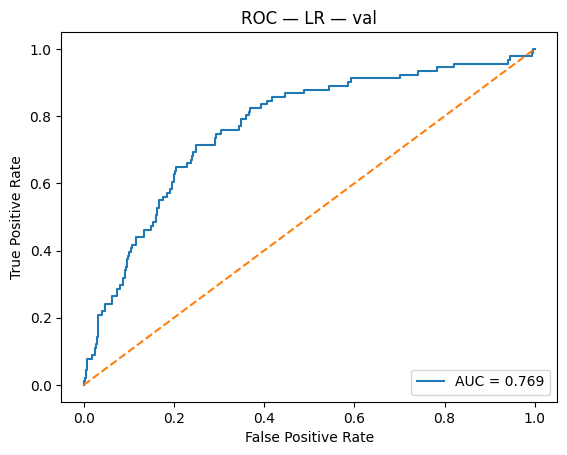


=== RF — val ===
Accuracy : 0.8983
F1 (macro / weighted): 0.5499 / 0.8718
AUC-ROC : 0.7124

Per-class metrics:
              precision    recall  f1-score   support

      class0     0.9134    0.9807    0.9459       882
      class1     0.3462    0.0989    0.1538        91

    accuracy                         0.8983       973
   macro avg     0.6298    0.5398    0.5499       973
weighted avg     0.8604    0.8983    0.8718       973

Confusion matrix:


,pred_class0,pred_class1
true_class0,865,17
true_class1,82,9


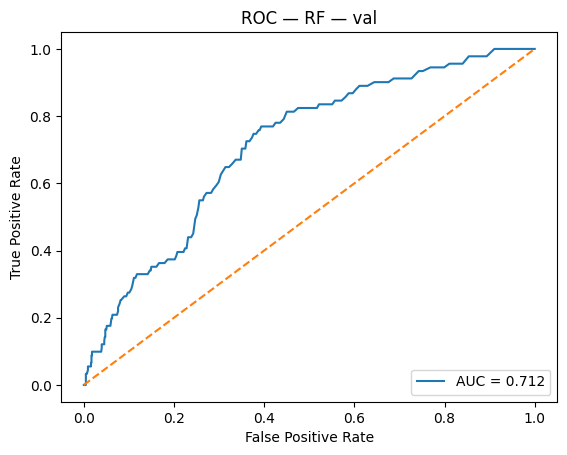


=== XGB — val ===
Accuracy : 0.8849
F1 (macro / weighted): 0.5248 / 0.8611
AUC-ROC : 0.7085

Per-class metrics:
              precision    recall  f1-score   support

      class0     0.9104    0.9683    0.9385       882
      class1     0.2000    0.0769    0.1111        91

    accuracy                         0.8849       973
   macro avg     0.5552    0.5226    0.5248       973
weighted avg     0.8440    0.8849    0.8611       973

Confusion matrix:


,pred_class0,pred_class1
true_class0,854,28
true_class1,84,7


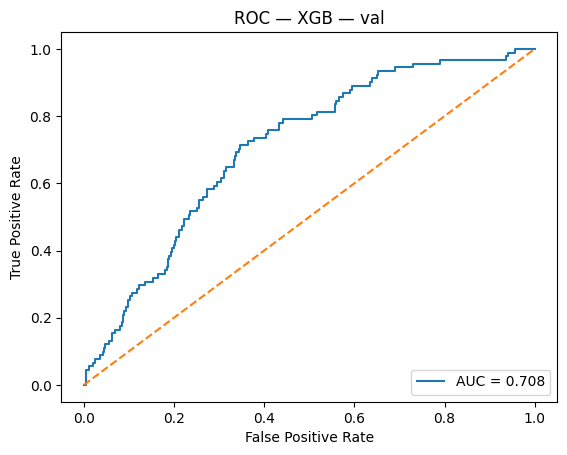


=== MLP — val ===
Accuracy : 0.8736
F1 (macro / weighted): 0.5417 / 0.8588
AUC-ROC : 0.6987

Per-class metrics:
              precision    recall  f1-score   support

      class0     0.9129    0.9512    0.9317       882
      class1     0.2037    0.1209    0.1517        91

    accuracy                         0.8736       973
   macro avg     0.5583    0.5361    0.5417       973
weighted avg     0.8466    0.8736    0.8588       973

Confusion matrix:


,pred_class0,pred_class1
true_class0,839,43
true_class1,80,11


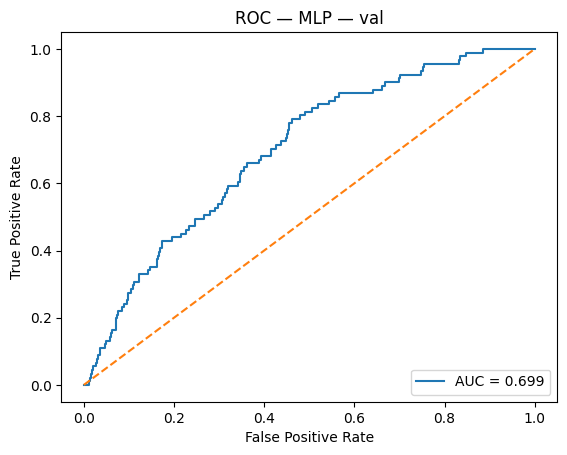


=== TabNet — val ===
Accuracy : 0.4604
F1 (macro / weighted): 0.4012 / 0.5543
AUC-ROC : 0.6184

Per-class metrics:
              precision    recall  f1-score   support

      class0     0.9496    0.4274    0.5895       882
      class1     0.1233    0.7802    0.2129        91

    accuracy                         0.4604       973
   macro avg     0.5364    0.6038    0.4012       973
weighted avg     0.8723    0.4604    0.5543       973

Confusion matrix:


,pred_class0,pred_class1
true_class0,377,505
true_class1,20,71


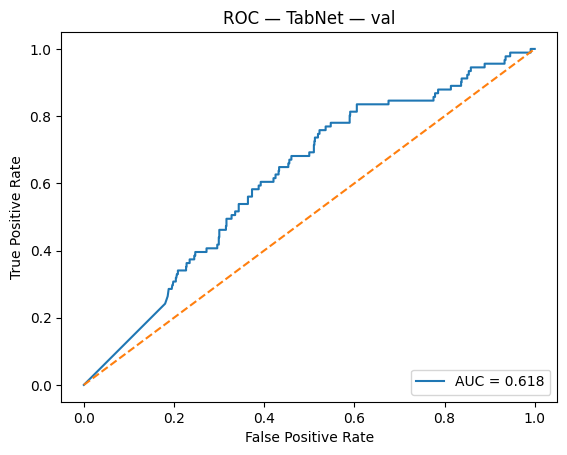

In [39]:
# Binary example with your setup
evaluate_classifier(models["lr"],     X_val_scaled, y_val, class_names=["class0","class1"], title="LR — val")
evaluate_classifier(models["rf"],     X_val,        y_val, class_names=["class0","class1"], title="RF — val")
evaluate_classifier(models["xgb"],    X_val,        y_val, class_names=["class0","class1"], title="XGB — val")
evaluate_classifier(models["mlp"],    X_val_scaled, y_val, class_names=["class0","class1"], title="MLP — val")

# Only TabNet needs array input
# evaluate_classifier(models["tabnet"], X_val,        y_val, class_names=["class0","class1"], title="TabNet — val")
evaluate_classifier(models["tabnet"], X_val.values, y_val, class_names=["class0","class1"], title="TabNet — val")



In [40]:
# ============================================================
# 6) Test metrics
# ============================================================
def proba_np(model, X):
    if isinstance(model, (TabNetClassifier)):
        return model.predict_proba(X.values if isinstance(X, pd.DataFrame) else X)
    return model.predict_proba(X)

with Timer("Test-set metrics"):
    test_metrics = {
        "lr":     perf_summary(y_test.values, proba_np(lr,     X_test_scaled)[:,1]),
        "rf":     perf_summary(y_test.values, proba_np(rf,     X_test)[:,1]),
        "xgb":    perf_summary(y_test.values, proba_np(xgb,    X_test)[:,1]),
        "mlp":    perf_summary(y_test.values, proba_np(mlp,    X_test_scaled)[:,1]),
        "tabnet": perf_summary(y_test.values, proba_np(tn,     X_test)[:,1]),
    }
    test_df = pd.DataFrame(test_metrics).T[["roc_auc","pr_auc","ece"]]
    print(test_df.round(4))


[15:11:57] START: Test-set metrics
        roc_auc  pr_auc     ece
lr       0.8002  0.3152  0.0496
rf       0.7737  0.2678  0.0623
xgb      0.7563  0.2849  0.0562
mlp      0.7420  0.2464  0.0695
tabnet   0.5921  0.1117  0.3718
[15:11:57] END:   Test-set metrics  (took 0.38s)



#### COMPUTE WEIGHT OF EACH MODEL

In [41]:
import numpy as np
import pandas as pd

def _safe(values, floor=1e-8):
    v = pd.Series(values).astype(float)
    v = v.fillna(0.0).clip(lower=0.0)
    return v.where(v > 0, floor)

def make_weights(
    perf_df: pd.DataFrame,
    use_models: list[str],
    metric: str = "roc_auc",      # or "pr_auc"
    calibrate: bool = True,       # multiply by (1 - ece)
    power: float = 1.0,           # >1 accentuates winners; <1 flattens
    temp: float | None = None,    # if set, do softmax with temperature instead of sum-1
    floor: float = 1e-8           # avoids zeros
) -> pd.Series:
    """
    Returns normalized weights for models in `use_models`.
    - If `temp` is None -> L1-normalized (sum to 1).
    - If `temp` is set  -> softmax-normalized with temperature (lower temp = peakier).
    """
    sub = perf_df.loc[use_models]

    # base score from the chosen metric
    score = _safe(sub[metric], floor=floor)

    # optional calibration bonus
    if calibrate and "ece" in sub:
        cal = (1.0 - _safe(1.0 - sub["ece"], floor=floor))  # ensures 1-ece in (floor,1]
        # simpler: just multiply by (1 - ece)
        cal = (1.0 - sub["ece"]).clip(lower=floor)
        score = score * cal

    # optional power scaling
    if power != 1.0:
        score = (score ** power).clip(lower=floor)

    # normalization
    if temp is None:
        w = score / score.sum()
    else:
        # softmax with temperature
        s = np.log(score)
        s = (s - s.max()) / max(temp, 1e-6)
        ex = np.exp(s)
        w = ex / ex.sum()

    w.name = "weight"
    return w.round(6)

def make_weights_combo(
    perf_df: pd.DataFrame,
    use_models: list[str],
    metrics: tuple[str, str] = ("roc_auc", "pr_auc"),
    mix: str = "geo",            # "geo" (geometric) or "arith" (arithmetic)
    calibrate: bool = True,
    power: float = 1.0,
    temp: float | None = None,
    floor: float = 1e-8
) -> pd.Series:
    """
    Combine two metrics into one score before normalization.
    - geo: sqrt(m1 * m2)   (recommended)
    - arith: 0.5*(m1 + m2)
    """
    sub = perf_df.loc[use_models]
    m1 = _safe(sub[metrics[0]], floor=floor)
    m2 = _safe(sub[metrics[1]], floor=floor)

    if mix == "geo":
        score = np.sqrt(m1 * m2)
    else:
        score = 0.5 * (m1 + m2)

    if calibrate and "ece" in sub:
        score = score * (1.0 - sub["ece"]).clip(lower=floor)

    if power != 1.0:
        score = (score ** power).clip(lower=floor)

    if temp is None:
        w = score / score.sum()
    else:
        s = np.log(score)
        s = (s - s.max()) / max(temp, 1e-6)
        ex = np.exp(s)
        w = ex / ex.sum()

    w.name = "weight"
    return w.round(6)


In [42]:
# Use ROC-AUC × (1 - ECE), L1-normalized
w1 = make_weights(perf_df, use_models, metric="roc_auc", calibrate=True)

# Or combine ROC-AUC and PR-AUC via geometric mean, with calibration
w2 = make_weights_combo(perf_df, use_models, metrics=("roc_auc","pr_auc"), mix="geo", calibrate=True)

print("Weights (roc_auc × (1-ece)):\n", w1)
print("Weights (geo(roc_auc, pr_auc) × (1-ece)):\n", w2)



Weights (roc_auc × (1-ece)):
 lr        0.237918
rf        0.216582
xgb       0.213164
mlp       0.209000
tabnet    0.123336
Name: weight, dtype: float64
Weights (geo(roc_auc, pr_auc) × (1-ece)):
 lr        0.266942
rf        0.217992
xgb       0.207846
mlp       0.200103
tabnet    0.107117
Name: weight, dtype: float64


In [43]:
# phi_comp = sum(w1[m] * shap_dict[m] for m in w1.index)
# print(phi_comp)

### SHAP Analysis

In [44]:
# ============================================================
# 4) SHAP
# ============================================================
def compute_default_shap(imp_mag_default={}, imp_signed_default={}):

    with Timer("SHAP: Linear (LR) + Tree (RF, XGB)"):
        bg_idx_lin  = sub_idx(len(X_train_res_scaled), LIN_BG_MAX)
        ev_idx_lin  = sub_idx(len(X_val_scaled),      LIN_EV_MAX)
        bg_idx_tr   = sub_idx(len(X_train_res), TREE_BG_MAX)
        ev_idx_tr   = sub_idx(len(X_val),      TREE_EV_MAX)
    
        if "lr" in use_models:
            stamp(f"[LR] Linear SHAP on scaled: bg={len(bg_idx_lin)}, eval={len(ev_idx_lin)}")
            imp_mag_default["lr"]    = linear_shap_lr(lr, X_train_res_scaled.iloc[bg_idx_lin], X_val_scaled.iloc[ev_idx_lin], feat_names, signed=False)
            imp_signed_default["lr"] = linear_shap_lr(lr, X_train_res_scaled.iloc[bg_idx_lin], X_val_scaled.iloc[ev_idx_lin], feat_names, signed=True)
    
        if "rf" in use_models:
            stamp(f"[RF] Tree SHAP on unscaled: bg={len(bg_idx_tr)}, eval={len(ev_idx_tr)}")
            imp_mag_default["rf"]    = tree_shap(rf,  X_train_res.iloc[bg_idx_tr], X_val.iloc[ev_idx_tr], feat_names, signed=False)
            imp_signed_default["rf"] = tree_shap(rf,  X_train_res.iloc[bg_idx_tr], X_val.iloc[ev_idx_tr], feat_names, signed=True)
    
        if "xgb" in use_models:
            stamp(f"[XGB] Tree SHAP on unscaled: bg={len(bg_idx_tr)}, eval={len(ev_idx_tr)}")
            imp_mag_default["xgb"]    = tree_shap(xgb, X_train_res.iloc[bg_idx_tr], X_val.iloc[ev_idx_tr], feat_names, signed=False)
            imp_signed_default["xgb"] = tree_shap(xgb, X_train_res.iloc[bg_idx_tr], X_val.iloc[ev_idx_tr], feat_names, signed=True)
    
    def explain_blackbox_fast(name, predict_proba_fn, X_bg_df, X_ev_df, feat_names, signed=False):
        X_bg_np = kmeans_background(X_bg_df.values, k=HEAVY_BG_K, random_state=RANDOM_STATE)
        n_eval = min(HEAVY_EV_K, len(X_ev_df))
        X_ev_np = X_ev_df.sample(n=n_eval, random_state=RANDOM_STATE).values if len(X_ev_df) > n_eval else X_ev_df.values
        stamp(f"[{name}] SHAP ({'Permutation' if SHAP_BACKEND!='kernel' else 'Kernel'}) with kmeans-bg={HEAVY_BG_K}, eval={n_eval}")
        if SHAP_BACKEND == "kernel":
            return kernel_shap_from_proba(predict_proba_fn, X_bg_np, X_ev_np, feat_names, signed=signed)
        else:
            return perm_shap_from_proba(predict_proba_fn, X_bg_np, X_ev_np, feat_names, signed=signed)
    
    with Timer("SHAP: Heavy models (MLP, TabNet)"):
        if "mlp" in use_models:
            imp_mag_default["mlp"]    = explain_blackbox_fast("MLP",    lambda Z: mlp.predict_proba(Z), X_train_res_scaled, X_val_scaled, feat_names, signed=False)
            imp_signed_default["mlp"] = explain_blackbox_fast("MLP",    lambda Z: mlp.predict_proba(Z), X_train_res_scaled, X_val_scaled, feat_names, signed=True)
        if "tabnet" in use_models:
            imp_mag_default["tabnet"]    = explain_blackbox_fast("TabNet", lambda Z: tn.predict_proba(Z), X_train_res, X_val, feat_names, signed=False)
            imp_signed_default["tabnet"] = explain_blackbox_fast("TabNet", lambda Z: tn.predict_proba(Z), X_train_res, X_val, feat_names, signed=True)
    
    return imp_mag_default, imp_signed_default

# UNCOMMENT FOLLOWING LINES TO RUN DEFAULT SHAP
imp_mag_default, imp_signed_default = {}, {}
# imp_mag_default, imp_signed_default  = compute_default_shap(imp_mag_default, imp_signed_default )


### Permutation SHAP

In [45]:
import numpy as np
import pandas as pd
import shap
import inspect

def _to_numpy(x):
    # Unwrap SHAP DenseData or similar wrappers to raw numpy
    if hasattr(x, "data"):      # DenseData has .data
        return np.asarray(x.data)
    return np.asarray(x)

def permutation_shap_proba(
    model,
    X_bg_df,
    X_ev_df,
    feature_names=None,
    n_bg=32,
    n_eval=64,
    random_state=0,
    class_index="auto",   # "auto" -> 1 for binary else 0
    aggregate="mean_abs", # "mean_abs" | "sum_abs"
):
    rng = np.random.default_rng(random_state)

    # --- arrays ---
    X_bg_np = _to_numpy(X_bg_df.values if hasattr(X_bg_df, "values") else X_bg_df)
    X_ev_np = _to_numpy(X_ev_df.values if hasattr(X_ev_df, "values") else X_ev_df)

    # --- k-means background (may return DenseData in older SHAP) ---
    try:
        bg = shap.kmeans(X_bg_np, k=min(n_bg, len(X_bg_np)), random_state=random_state)
    except TypeError:
        bg = shap.kmeans(X_bg_np, k=min(n_bg, len(X_bg_np)))
    X_bg_np = _to_numpy(bg)  # <-- unwrap DenseData to np array

    # --- subsample eval ---
    if len(X_ev_np) > n_eval:
        idx = rng.choice(len(X_ev_np), size=n_eval, replace=False)
        X_ev_np = X_ev_np[idx]

    # --- feature names ---
    if feature_names is None:
        if hasattr(X_bg_df, "columns"):
            feature_names = list(X_bg_df.columns)
        else:
            feature_names = [f"f{i}" for i in range(X_bg_np.shape[1])]

    # --- callable masker (must receive numpy, not DenseData) ---
    callable_masker = shap.maskers.Independent(X_bg_np)

    # --- construct explainer (prefer modern APIs) ---
    explainer = None
    errors = []

    try:
        explainer = shap.Explainer(model.predict_proba, callable_masker, algorithm="permutation")
    except Exception as e:
        errors.append(f"Explainer(permutation) -> {type(e).__name__}: {e}")

    if explainer is None:
        try:
            explainer = shap.explainers.Permutation(model.predict_proba, masker=callable_masker, feature_names=feature_names)
        except Exception as e:
            errors.append(f"Permutation(masker=) -> {type(e).__name__}: {e}")

    if explainer is None:
        try:
            sig = inspect.signature(shap.PermutationExplainer.__init__)
            if "masker" in sig.parameters:
                explainer = shap.PermutationExplainer(model.predict_proba, masker=callable_masker, feature_names=feature_names)
            else:
                raise RuntimeError("PermutationExplainer lacks 'masker' in this SHAP version; skip DenseData path.")
        except Exception as e:
            errors.append(f"Legacy PermutationExplainer(masker=) -> {type(e).__name__}: {e}")

    if explainer is None:
        raise RuntimeError("Could not construct a permutation explainer:\n- " + "\n- ".join(errors))

    # --- compute SHAP with modern call path (returns Explanation) ---
    sv = explainer(X_ev_np)
    values = sv.values
    base_values = sv.base_values

    # normalize shapes to (n_eval, n_feat, n_classes)
    if values.ndim == 2:
        values = values[:, :, None]
        if base_values.ndim == 1:
            base_values = base_values[:, None]

    n_eval, n_feat, n_classes = values.shape
    if class_index == "auto":
        cls_idx = 1 if n_classes == 2 else 0
    else:
        cls_idx = int(class_index)
        if not (0 <= cls_idx < n_classes):
            raise ValueError(f"class_index {cls_idx} out of range [0, {n_classes-1}]")

    if aggregate == "mean_abs":
        agg_abs = np.mean(np.abs(values[:, :, cls_idx]), axis=0)
        agg_signed = np.mean(values[:, :, cls_idx], axis=0)
    elif aggregate == "sum_abs":
        agg_abs = np.sum(np.abs(values[:, :, cls_idx]), axis=0)
        agg_signed = np.sum(values[:, :, cls_idx], axis=0)
    else:
        raise ValueError("aggregate must be 'mean_abs' or 'sum_abs'")

    abs_s = pd.Series(agg_abs, index=feature_names, name="shap_abs")
    signed_s = pd.Series(agg_signed, index=feature_names, name="shap_signed")
    denom = abs_s.abs().sum()
    norm_s = (abs_s.abs() / denom) if denom and pd.notna(denom) else abs_s.abs()
    norm_s.name = "shap_norm"

    meta = {
        "n_eval": int(n_eval),
        "n_bg": int(len(X_bg_np)),
        "n_classes": int(n_classes),
        "class_index": int(cls_idx),
    }
    return {"abs": abs_s, "signed": signed_s, "norm": norm_s, "meta": meta}


# --- utils: stack + composite (if you haven't added these yet) ---
import numpy as np, pandas as pd

def _stack_and_align(imp_dict: dict) -> pd.DataFrame:
    all_feats = sorted(set().union(*[s.index for s in imp_dict.values()]))
    cols = {m: s.reindex(all_feats).fillna(0.0) for m, s in imp_dict.items()}
    return pd.DataFrame(cols, index=all_feats)

def composite_from_permuta(imp_mag_dict, imp_signed_dict, weights: pd.Series, scale: str = "sum1"):
    common = sorted(set(imp_mag_dict).intersection(imp_signed_dict).intersection(weights.index))
    if not common:
        raise ValueError("No overlap between models in SHAP dicts and weights.")
    w = (weights.loc[common].astype(float) / weights.loc[common].sum())
    A = _stack_and_align({m: imp_mag_dict[m] for m in common})
    S = _stack_and_align({m: imp_signed_dict[m] for m in common})
    comp_abs   = A.dot(w)
    comp_value = S.dot(w)
    comp_df = pd.DataFrame({"comp_abs": comp_abs, "comp_value": comp_value}).sort_values("comp_abs", ascending=False)
    if scale == "sum1":
        # comp_df["comp_norm"] = comp_df["comp_abs"] / comp_df["comp_abs"].sum().clip(lower=1e-12)
        den = float(comp_df["comp_abs"].sum())
        den = max(den, 1e-12)
        comp_df["comp_norm"] = comp_df["comp_abs"] / den

    
    return comp_df, w



In [46]:
# --- 1) Compute permutation SHAP for your black-box models ---

def compute_permutation_shap(imp_mag_permuta = {}, imp_signed_permuta = {}):
    
    # --- Permutation SHAP for LR, RF, XGB, MLP, TabNet (model-agnostic, probability space) ---
    # LR (trained on *scaled* data)
    res_lr = permutation_shap_proba(
        model=lr,
        X_bg_df=X_train_res_scaled,
        X_ev_df=X_val_scaled,
        feature_names=list(X_train_res_scaled.columns),
        n_bg=32, n_eval=64, random_state=RANDOM_STATE, class_index="auto"
    )
    imp_mag_permuta["lr"]    = res_lr["abs"]
    imp_signed_permuta["lr"] = res_lr["signed"]
    
    # RF (trained on *unscaled* data)
    res_rf = permutation_shap_proba(
        model=rf,
        X_bg_df=X_train_res,
        X_ev_df=X_val,
        feature_names=list(X_train_res.columns),
        n_bg=32, n_eval=64, random_state=RANDOM_STATE, class_index="auto"
    )
    imp_mag_permuta["rf"]    = res_rf["abs"]
    imp_signed_permuta["rf"] = res_rf["signed"]
    
    # XGB (trained on *unscaled* data)
    # Make sure xgb.predict_proba returns probabilities (it does for XGBClassifier)
    res_xgb = permutation_shap_proba(
        model=xgb,
        X_bg_df=X_train_res,
        X_ev_df=X_val,
        feature_names=list(X_train_res.columns),
        n_bg=32, n_eval=64, random_state=RANDOM_STATE, class_index="auto"
    )
    imp_mag_permuta["xgb"]    = res_xgb["abs"]
    imp_signed_permuta["xgb"] = res_xgb["signed"]
    
    
    # For MLP (trained on *scaled* data)
    res_mlp = permutation_shap_proba(
        model=mlp,
        X_bg_df=X_train_res_scaled,
        X_ev_df=X_val_scaled,
        feature_names=list(X_train_res_scaled.columns),
        n_bg=32,          # k-means background size
        n_eval=64,        # eval subsample size
        random_state=RANDOM_STATE,
        class_index="auto",   # or 1 for binary positive class
        aggregate="mean_abs"  # or "sum_abs"
    )
    imp_mag_permuta["mlp"]    = res_mlp["abs"]     # |SHAP|
    imp_signed_permuta["mlp"] = res_mlp["signed"]  # signed SHAP
    
    # For TabNet (trained on *unscaled* data)
    res_tn = permutation_shap_proba(
        model=tn,
        X_bg_df=X_train_res,
        X_ev_df=X_val,
        feature_names=list(X_train_res.columns),
        n_bg=32, n_eval=64, random_state=RANDOM_STATE, class_index="auto"
    )
    imp_mag_permuta["tabnet"]    = res_tn["abs"]
    imp_signed_permuta["tabnet"] = res_tn["signed"]


    # ---- Composite with w1 ----
    comp_df_w1, w_used_w1 = composite_from_permuta(
        imp_mag_dict=imp_mag_permuta,
        imp_signed_dict=imp_signed_permuta,
        weights=w1,
        scale="sum1"
    )
    # store like any model
    imp_mag_permuta["composite_w1"]    = comp_df_w1["comp_abs"]
    imp_signed_permuta["composite_w1"] = comp_df_w1["comp_value"]
    
    # ---- (optional) Composite with w2 as a second variant ----
    comp_df_w2, w_used_w2 = composite_from_permuta(
        imp_mag_dict=imp_mag_permuta,
        imp_signed_dict=imp_signed_permuta,
        weights=w2,
        scale="sum1"
    )
    imp_mag_permuta["composite_w2"]    = comp_df_w2["comp_abs"]
    imp_signed_permuta["composite_w2"] = comp_df_w2["comp_value"]
    
    # (Optional) You can inspect details like:
    # print(res_mlp["meta"], res_tn["meta"])

    return imp_mag_permuta, imp_signed_permuta


imp_mag_permuta, imp_signed_permuta = {}, {}
imp_mag_permuta, imp_signed_permuta = compute_permutation_shap(imp_mag_permuta, imp_signed_permuta)

PermutationExplainer explainer: 65it [03:55,  3.79s/it]                                                                                                                                                                                      
PermutationExplainer explainer: 65it [00:25,  1.56it/s]                                                                                                                                                                                      


In [47]:
# --- 2) Build the feature table with columns: abs, value, norm (per model) ---

import pandas as pd

model_order = ["lr", "rf", "xgb", "mlp", "tabnet", "composite_w1", "composite_w2"]  # include only what you computed
models = [m for m in model_order if (m in imp_mag_permuta) and (m in imp_signed_permuta)]

def _as_series(x):
    if isinstance(x, pd.Series): return x
    if isinstance(x, pd.DataFrame):
        num_cols = [c for c in x.columns if pd.api.types.is_numeric_dtype(x[c])]
        return x[num_cols[0]]
    raise TypeError(f"Unexpected importance type: {type(x)}")

frames = []
for m in models:
    mag = _as_series(imp_mag_permuta[m])      # |SHAP|
    sgn = _as_series(imp_signed_permuta[m])   # signed SHAP
    mag, sgn = mag.align(sgn, join="outer")
    denom = mag.abs().sum()
    norm = mag.abs() / denom if denom and pd.notna(denom) else mag.abs()
    frames.append(pd.DataFrame({
        f"{m} (shap abs)":   mag.abs(),
        f"{m} (shap value)": sgn,
        f"{m} (shap norm)":  norm
    }))

feat_tbl_permuta = pd.concat(frames, axis=1)
feat_tbl_permuta = feat_tbl_permuta.rename_axis("feature").reset_index()

# (Optional) sort rows by average normalized importance across models
norm_cols = [c for c in feat_tbl_permuta.columns if c.endswith("(shap norm)")]
feat_tbl_permuta["avg_norm"] = feat_tbl_permuta[norm_cols].mean(axis=1, skipna=True)
feat_tbl_permuta = feat_tbl_permuta.sort_values("avg_norm", ascending=False).drop(columns=["avg_norm"])

feat_tbl_permuta.head(30)


,feature,lr (shap abs),lr (shap value),lr (shap norm),rf (shap abs),rf (shap value),rf (shap norm),xgb (shap abs),xgb (shap value),xgb (shap norm),...,mlp (shap norm),tabnet (shap abs),tabnet (shap value),tabnet (shap norm),composite_w1 (shap abs),composite_w1 (shap value),composite_w1 (shap norm),composite_w2 (shap abs),composite_w2 (shap value),composite_w2 (shap norm)
17,GeneralHealth_Good,0.221886,-0.158975,0.167072,0.151324,-0.144992,0.179371,0.227802,-0.216833,0.202948,...,0.160040,0.110284,0.100642,0.128354,0.194405,-0.135650,0.171191,0.196071,-0.139559,0.171538
22,smokeStat_Never,0.238951,-0.113956,0.179922,0.156478,-0.092250,0.185480,0.182582,-0.116316,0.162662,...,0.160885,0.017811,0.002297,0.020729,0.178783,-0.093860,0.157434,0.182682,-0.095768,0.159824
16,GeneralHealth_VeryGood,0.168729,-0.061649,0.127047,0.115062,-0.086852,0.136388,0.159248,-0.118994,0.141874,...,0.121277,0.039454,0.017825,0.045919,0.139249,-0.069964,0.122621,0.141316,-0.070965,0.123634
21,smokeStat_Former,0.129735,-0.069765,0.097686,0.063870,-0.056717,0.075708,0.094163,-0.085993,0.083890,...,0.082296,0.008871,-0.006585,0.010325,0.089869,-0.059739,0.079138,0.092058,-0.060781,0.080539
9,Age,0.051780,-0.000412,0.038989,0.076898,0.007515,0.091151,0.069571,0.016585,0.061981,...,0.039515,0.123007,0.011745,0.143161,0.070501,0.007960,0.062082,0.069257,0.007618,0.060591
20,smokeStat_Current,0.073095,-0.007976,0.055038,0.035419,-0.026654,0.041984,0.048950,-0.032759,0.043609,...,0.054720,0.005602,-0.000615,0.006520,0.052147,-0.016865,0.045920,0.053288,-0.016859,0.046621
18,GeneralHealth_Fair,0.066985,-0.044658,0.050437,0.028307,-0.024110,0.033553,0.064554,-0.050026,0.057511,...,0.048753,0.005180,-0.003534,0.006029,0.050687,-0.036993,0.044634,0.051638,-0.037572,0.045177
25,eCigUse_Never,0.111054,-0.044568,0.083620,0.005158,-0.001969,0.006114,0.014900,-0.003666,0.013274,...,0.069187,0.014435,-0.003660,0.016800,0.052675,-0.020209,0.046385,0.054733,-0.021088,0.047885
15,GeneralHealth_Excellent,0.065709,-0.008054,0.049477,0.032979,-0.032979,0.039091,0.046902,-0.046902,0.041785,...,0.049148,0.006682,-0.003067,0.007777,0.047933,-0.021561,0.042209,0.048919,-0.021451,0.042798
0,FreqGoProvider,0.011064,-0.000374,0.008331,0.017191,-0.004657,0.020377,0.021928,-0.002619,0.019535,...,0.011183,0.106791,0.042166,0.124288,0.027463,0.002574,0.024183,0.025821,0.001928,0.022590


In [48]:
# --- 3) Export the table (CSV + Excel + Parquet optional) ---

with Timer("Exporting the SHAP values csv file"):
    
    from datetime import datetime
    from pathlib import Path
    
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_csv  = f"shap_feature_table_{ts}.csv"
    # Ensure the directory exists
    out_dir = Path("op/shap_analy")
    out_dir.mkdir(parents=True, exist_ok=True)
    
    # Choose a filename (timestamped to avoid overwrites)
    out_csv = out_dir / f"shap_feature_table_permutation_{ts}.csv"
    
    # Save the table
    feat_tbl_permuta.to_csv(out_csv, index=False)
    
    print(f"Saved CSV to: {out_csv}")



[15:16:54] START: Exporting the SHAP values csv file
Saved CSV to: op/shap_analy/shap_feature_table_permutation_20251015_151654.csv
[15:16:54] END:   Exporting the SHAP values csv file  (took 0.01s)



#### Kernel SHAP

In [49]:
# --- Robust Kernel SHAP for predict_proba (model-agnostic) -------------------
import numpy as np
import pandas as pd
import shap
import inspect

def _to_numpy(x):
    # Unwrap SHAP DenseData or similar wrappers to raw numpy
    if hasattr(x, "data"):  # DenseData has .data
        return np.asarray(x.data)
    return np.asarray(x)

def kernel_shap_proba(
    model,
    X_bg_df,
    X_ev_df,
    feature_names=None,
    n_bg=32,
    n_eval=64,
    random_state=0,
    class_index="auto",    # "auto" -> 1 for binary else 0, or pass an int
    link="identity",       # "identity" or "logit"
    nsamples="auto",       # controls runtime; int or "auto"
    aggregate="mean_abs",  # "mean_abs" | "sum_abs"
):
    """
    Kernel SHAP on model.predict_proba for a single class (chosen via class_index).
    Returns dict: {"abs": Series, "signed": Series, "norm": Series, "meta": {...}}
    """
    rng = np.random.default_rng(random_state)

    # --- arrays + optional subsampling ---
    X_bg_np = _to_numpy(X_bg_df.values if hasattr(X_bg_df, "values") else X_bg_df)
    X_ev_np = _to_numpy(X_ev_df.values if hasattr(X_ev_df, "values") else X_ev_df)

    # Summarize background via k-means (unwrap DenseData if returned)
    try:
        bg = shap.kmeans(X_bg_np, k=min(n_bg, len(X_bg_np)), random_state=random_state)
    except TypeError:
        bg = shap.kmeans(X_bg_np, k=min(n_bg, len(X_bg_np)))
    X_bg_np = _to_numpy(bg)

    if len(X_ev_np) > n_eval:
        idx = rng.choice(len(X_ev_np), size=n_eval, replace=False)
        X_ev_np = X_ev_np[idx]

    # Feature names
    if feature_names is None:
        if hasattr(X_bg_df, "columns"):
            feature_names = list(X_bg_df.columns)
        else:
            feature_names = [f"f{i}" for i in range(X_bg_np.shape[1])]

    # --- determine class index from a probe call ---
    proba_probe = model.predict_proba(X_ev_np[: min(8, len(X_ev_np))])
    if proba_probe.ndim == 1:
        proba_probe = proba_probe[:, None]
    n_classes = proba_probe.shape[1]
    if class_index == "auto":
        cls_idx = 1 if n_classes == 2 else 0
    else:
        cls_idx = int(class_index)
        if not (0 <= cls_idx < n_classes):
            raise ValueError(f"class_index {cls_idx} out of range [0, {n_classes-1}]")

    # Wrap predict_proba to scalar output (KernelExplainer prefers scalar f)
    def f_cls(Z):
        p = model.predict_proba(Z)
        if p.ndim == 1:
            return p  # already scalar per row
        return p[:, cls_idx]

    # Link
    if link == "identity":
        link_obj = getattr(shap.links, "identity", shap.links.identity)
    elif link == "logit":
        link_obj = getattr(shap.links, "logit", shap.links.logit)
    else:
        raise ValueError("link must be 'identity' or 'logit'")

    # --- Build explainer (prefer modern APIs) ---
    explainer = None
    errs = []

    # A) Unified API
    try:
        masker = shap.maskers.Independent(X_bg_np)
        explainer = shap.Explainer(f_cls, masker, algorithm="kernel", link=link_obj)
    except Exception as e:
        errs.append(f"Explainer(kernel) -> {type(e).__name__}: {e}")

    # B) New-style Kernel explainer
    if explainer is None:
        try:
            masker = shap.maskers.Independent(X_bg_np)
            explainer = shap.explainers.Kernel(f_cls, masker=masker, link=link_obj)
        except Exception as e:
            errs.append(f"explainers.Kernel(masker=) -> {type(e).__name__}: {e}")

    # C) Legacy KernelExplainer(data=bg)
    if explainer is None:
        try:
            # Legacy expects data array, not masker
            explainer = shap.KernelExplainer(f_cls, X_bg_np, link=link)
        except Exception as e:
            errs.append(f"KernelExplainer(data) -> {type(e).__name__}: {e}")

    if explainer is None:
        raise RuntimeError("Could not construct Kernel explainer:\n- " + "\n- ".join(errs))

    # --- Compute SHAP values (handle both new/old call signatures) ---
    values = None
    base_value = None
    call_errs = []

    # Style 1: new API -> Explanation via explainer(X, max_evals=...)
    try:
        kwargs = {}
        if nsamples != "auto":
            # In new API, 'nsamples' ~ 'max_evals'
            kwargs["max_evals"] = int(nsamples)
        sv = explainer(X_ev_np, **kwargs)
        # Explanation for scalar f -> (n_eval, n_feat)
        values = sv.values
        # base_values is (n_eval,) for scalar output
        base_value = np.mean(np.atleast_1d(sv.base_values))
    except Exception as e:
        call_errs.append(f"call_new:{type(e).__name__}: {e}")

    # Style 2: legacy -> explainer.shap_values(X, nsamples=...)
    if values is None:
        try:
            kwargs = {}
            if nsamples != "auto":
                kwargs["nsamples"] = int(nsamples)
            shap_vals = explainer.shap_values(X_ev_np, **kwargs)  # (n_eval, n_feat)
            values = np.asarray(shap_vals)
            # expected_value may be scalar or array; we just store mean for meta
            ev = getattr(explainer, "expected_value", 0.0)
            base_value = float(np.mean(np.atleast_1d(ev)))
        except Exception as e:
            call_errs.append(f"call_legacy:{type(e).__name__}: {e}")

    if values is None:
        raise RuntimeError("Failed to compute Kernel SHAP via both call styles:\n- " + "\n- ".join(call_errs))

    # --- Aggregate across eval samples ---
    if aggregate == "mean_abs":
        agg_abs = np.mean(np.abs(values), axis=0)
        agg_signed = np.mean(values, axis=0)
    elif aggregate == "sum_abs":
        agg_abs = np.sum(np.abs(values), axis=0)
        agg_signed = np.sum(values, axis=0)
    else:
        raise ValueError("aggregate must be 'mean_abs' or 'sum_abs'")

    abs_s = pd.Series(agg_abs, index=feature_names, name="shap_abs")
    signed_s = pd.Series(agg_signed, index=feature_names, name="shap_signed")
    denom = abs_s.abs().sum()
    norm_s = (abs_s.abs() / denom) if denom and pd.notna(denom) else abs_s.abs()
    norm_s.name = "shap_norm"

    meta = {
        "n_eval": int(values.shape[0]),
        "n_bg": int(len(X_bg_np)),
        "n_classes": int(n_classes),
        "class_index": int(cls_idx),
        "link": link,
        "nsamples": nsamples,
        "base_value_mean": float(base_value),
    }
    return {"abs": abs_s, "signed": signed_s, "norm": norm_s, "meta": meta}


In [50]:

def compute_kernel_shap(imp_mag_kernel={}, imp_signed_kernel={}):

    # === LR on *scaled* data ===
    res_lr_k = kernel_shap_proba(
        model=lr,
        X_bg_df=X_train_res_scaled,
        X_ev_df=X_val_scaled,
        feature_names=list(X_train_res_scaled.columns),
        n_bg=32,
        n_eval=64,
        random_state=RANDOM_STATE,
        class_index="auto",
        link="identity",
        nsamples="auto"        # e.g., 2000 for tighter estimates
    )
    imp_mag_kernel["lr"]    = res_lr_k["abs"]
    imp_signed_kernel["lr"] = res_lr_k["signed"]
    
    # === RF on *unscaled* data ===
    res_rf_k = kernel_shap_proba(
        model=rf,
        X_bg_df=X_train_res,
        X_ev_df=X_val,
        feature_names=list(X_train_res.columns),
        n_bg=32,
        n_eval=64,
        random_state=RANDOM_STATE,
        class_index="auto",
        link="identity",
        nsamples="auto"
    )
    imp_mag_kernel["rf"]    = res_rf_k["abs"]
    imp_signed_kernel["rf"] = res_rf_k["signed"]
    
    # === XGBoost on *unscaled* data ===
    res_xgb_k = kernel_shap_proba(
        model=xgb,
        X_bg_df=X_train_res,
        X_ev_df=X_val,
        feature_names=list(X_train_res.columns),
        n_bg=32,
        n_eval=64,
        random_state=RANDOM_STATE,
        class_index="auto",
        link="identity",
        nsamples="auto"
    )
    imp_mag_kernel["xgb"]    = res_xgb_k["abs"]
    imp_signed_kernel["xgb"] = res_xgb_k["signed"]
    
    # MLP on *scaled* data (probability space)
    res_mlp_k = kernel_shap_proba(
        model=mlp,
        X_bg_df=X_train_res_scaled,
        X_ev_df=X_val_scaled,
        feature_names=list(X_train_res_scaled.columns),
        n_bg=32,
        n_eval=64,
        random_state=RANDOM_STATE,
        class_index="auto",  # or set 1 for positive class
        link="identity",     # try "logit" for log-odds if you prefer
        nsamples="auto"      # or an int like 2_000 for tighter estimates
    )
    imp_mag_kernel["mlp"]    = res_mlp_k["abs"]
    imp_signed_kernel["mlp"] = res_mlp_k["signed"]
    
    # TabNet on *unscaled* data
    res_tn_k = kernel_shap_proba(
        model=tn,
        X_bg_df=X_train_res,
        X_ev_df=X_val,
        feature_names=list(X_train_res.columns),
        n_bg=32, n_eval=64, random_state=RANDOM_STATE, class_index="auto",
        link="identity", nsamples="auto"
    )
    imp_mag_kernel["tabnet"]    = res_tn_k["abs"]
    imp_signed_kernel["tabnet"] = res_tn_k["signed"]

    
    # ---- Composite with w1 ----
    comp_df_w1, w_used_w1 = composite_from_permuta(
        imp_mag_dict=imp_mag_kernel,
        imp_signed_dict=imp_signed_kernel,
        weights=w1,
        scale="sum1"
    )
    # store like any model
    imp_mag_kernel["composite_w1"]    = comp_df_w1["comp_abs"]
    imp_signed_kernel["composite_w1"] = comp_df_w1["comp_value"]
    
    # ---- (optional) Composite with w2 as a second variant ----
    comp_df_w2, w_used_w2 = composite_from_permuta(
        imp_mag_dict=imp_mag_kernel,
        imp_signed_dict=imp_signed_kernel,
        weights=w2,
        scale="sum1"
    )
    imp_mag_kernel["composite_w2"]    = comp_df_w2["comp_abs"]
    imp_signed_kernel["composite_w2"] = comp_df_w2["comp_value"]

    
    return imp_mag_kernel, imp_signed_kernel


imp_mag_kernel, imp_signed_kernel = {}, {}
imp_mag_kernel, imp_signed_kernel = compute_kernel_shap(imp_mag_kernel, imp_signed_kernel)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 64/64 [01:32<00:00,  1.44s/it]


In [25]:
# === Build + display pretty + export Kernel SHAP feature table ===
import pandas as pd
from pathlib import Path
from datetime import datetime
from IPython.display import display  # pretty HTML display in notebooks

# 1) Choose models to include (only those present in imp_mag_kernel/imp_signed_permuta will be used)
model_order = ["lr", "rf", "xgb", "mlp", "tabnet", "composite_w1", "composite_w2"]  # adjust if you want only kernel-based models
models = [m for m in model_order if (m in imp_mag_kernel) and (m in imp_signed_permuta)]

def _as_series(x):
    if isinstance(x, pd.Series): return x
    if isinstance(x, pd.DataFrame):
        num_cols = [c for c in x.columns if pd.api.types.is_numeric_dtype(x[c])]
        return x[num_cols[0]]
    return pd.Series(x)

# 2) Build per-model columns: abs, signed, normalized
frames = []
for m in models:
    mag = _as_series(imp_mag_kernel[m])      # |SHAP| (from Kernel SHAP or other)
    sgn = _as_series(imp_signed_permuta[m])   # signed SHAP
    mag, sgn = mag.align(sgn, join="outer")
    denom = mag.abs().sum()
    norm = (mag.abs() / denom) if denom and pd.notna(denom) else mag.abs()
    frames.append(pd.DataFrame({
        f"{m} (shap abs)":   mag.abs(),
        f"{m} (shap value)": sgn,
        f"{m} (shap norm)":  norm
    }))

feat_tbl_kernel = pd.concat(frames, axis=1)
feat_tbl_kernel = feat_tbl_kernel.rename_axis("feature").reset_index()

# 3) Optional: sort rows by average normalized importance across included models
norm_cols = [c for c in feat_tbl_kernel.columns if c.endswith("(shap norm)")]
feat_tbl_kernel["avg_norm"] = feat_tbl_kernel[norm_cols].mean(axis=1, skipna=True)
feat_tbl_kernel = feat_tbl_kernel.sort_values("avg_norm", ascending=False).drop(columns=["avg_norm"])

# 4) Pretty display (HTML table, like your screenshot)
#    (no jinja2 / Styler needed)
display(feat_tbl_kernel.head(30))



,feature,lr (shap abs),lr (shap value),lr (shap norm),rf (shap abs),rf (shap value),rf (shap norm),xgb (shap abs),xgb (shap value),xgb (shap norm),...,mlp (shap norm),tabnet (shap abs),tabnet (shap value),tabnet (shap norm),composite_w1 (shap abs),composite_w1 (shap value),composite_w1 (shap norm),composite_w2 (shap abs),composite_w2 (shap value),composite_w2 (shap norm)
17,GeneralHealth_Good,0.220941,-0.155197,0.179414,0.146763,-0.143560,0.185936,0.223319,-0.219320,0.214355,...,0.178593,0.108451,0.104148,0.143748,0.191190,-0.134170,0.184574,0.192911,-0.138027,0.184782
22,smokeStat_Never,0.240054,-0.109983,0.194935,0.156492,-0.092322,0.198261,0.181541,-0.113027,0.174254,...,0.180324,0.009293,0.002761,0.012317,0.177153,-0.092165,0.171023,0.181254,-0.093984,0.173617
16,GeneralHealth_VeryGood,0.170522,-0.063619,0.138471,0.112779,-0.087368,0.142881,0.156643,-0.118445,0.150355,...,0.138904,0.032461,0.017205,0.043026,0.138057,-0.070393,0.133280,0.140288,-0.071450,0.134376
21,smokeStat_Former,0.131615,-0.066714,0.106877,0.060123,-0.057377,0.076171,0.088700,-0.086163,0.085140,...,0.094180,0.006775,-0.005436,0.008980,0.088262,-0.059661,0.085207,0.090555,-0.060607,0.086740
9,Age,0.046966,-0.001185,0.038139,0.075598,0.007785,0.095776,0.069040,0.017468,0.066269,...,0.038871,0.117193,0.017074,0.155335,0.066699,0.008911,0.064391,0.065476,0.008446,0.062717
20,smokeStat_Current,0.077278,-0.007130,0.062753,0.031298,-0.026714,0.039651,0.042885,-0.034265,0.041163,...,0.061567,0.004941,-0.001439,0.006550,0.050724,-0.017297,0.048969,0.052030,-0.017236,0.049837
15,GeneralHealth_Excellent,0.070620,-0.012213,0.057347,0.032553,-0.032629,0.041242,0.047067,-0.047610,0.045178,...,0.052395,0.005137,-0.002762,0.006809,0.047972,-0.022033,0.046313,0.049162,-0.022069,0.047090
25,eCigUse_Never,0.110154,-0.044800,0.089450,0.000393,-0.001994,0.000498,0.007920,-0.003275,0.007602,...,0.071639,0.007627,0.000244,0.010109,0.047317,-0.020462,0.045680,0.049566,-0.021381,0.047477
18,GeneralHealth_Fair,0.056157,-0.045666,0.045602,0.025861,-0.023562,0.032764,0.057773,-0.049253,0.055454,...,0.047317,0.002910,-0.001118,0.003857,0.043785,-0.036742,0.042270,0.044580,-0.037389,0.042702
0,FreqGoProvider,0.001916,-0.000766,0.001556,0.014441,-0.004222,0.018295,0.017425,-0.004328,0.016726,...,0.004484,0.097609,0.039304,0.129377,0.020488,0.001924,0.019779,0.018839,0.001320,0.018045


In [26]:
# --- 3) Export the table (CSV + Excel + Parquet optional) ---

with Timer("Exporting the SHAP values csv file"):
    
    from datetime import datetime
    from pathlib import Path
    
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_csv  = f"shap_feature_table_{ts}.csv"
    # Ensure the directory exists
    out_dir = Path("op/shap_analy")
    out_dir.mkdir(parents=True, exist_ok=True)
    
    # Choose a filename (timestamped to avoid overwrites)
    out_csv = out_dir / f"shap_feature_table_kernel_{ts}.csv"
    
    # Save the table
    feat_tbl_kernel.to_csv(out_csv, index=False)
    
    print(f"Saved CSV to: {out_csv}")



[12:59:10] START: Exporting the SHAP values csv file
Saved CSV to: op/shap_analy/shap_feature_table_kernel_20251008_125910.csv
[12:59:10] END:   Exporting the SHAP values csv file  (took 0.00s)



### PLOTTING

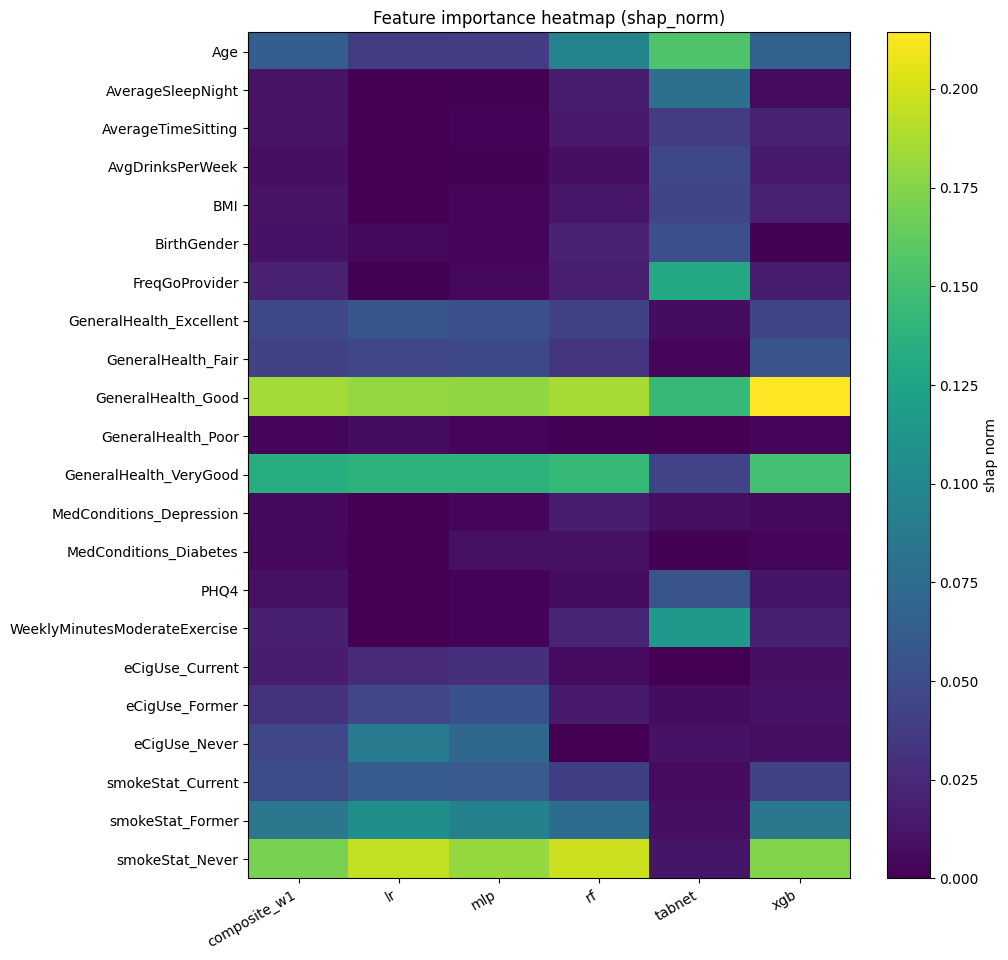

In [30]:
def plot_heatmap(models=None, top_k_per_model=15, metric="shap_norm"):
    df = shap_long
    if models is not None:
        df = df[df["model"].isin(models)].copy()

    # choose a union of top features across the selected models
    top_feats = (df.sort_values(metric, ascending=False)
                   .groupby("model")
                   .head(top_k_per_model)["feature"]
                   .unique())
    pivot = (df[df["feature"].isin(top_feats)]
             .pivot_table(index="feature", columns="model", values=metric, aggfunc="mean")
             .fillna(0))

    plt.figure(figsize=(1.2*len(pivot.columns)+3, 0.35*len(pivot.index)+2))
    plt.imshow(pivot.values, aspect="auto")
    plt.colorbar(label=metric.replace("_", " "))
    plt.yticks(range(len(pivot.index)), pivot.index)
    plt.xticks(range(len(pivot.columns)), pivot.columns, rotation=30, ha="right")
    plt.title(f"Feature importance heatmap ({metric})")
    plt.tight_layout()
    plt.show()

# examples:
plot_heatmap(models=["lr","rf","xgb","mlp","tabnet","composite_w1"], top_k_per_model=12, metric="shap_norm")


In [68]:
import matplotlib.patches as mpatches

# Color-blind friendly palette (Okabe–Ito)
palette = {
    "lr":           "#0072B2",  # blue
    "rf":           "#56B4E9",  # sky blue
    "xgb":          "#D55E00",  # vermillion
    "mlp":          "#CC79A7",  # reddish purple
    "tabnet":       "#E69F00",  # orange
    "composite_w1": "#009E73",  # green
    "composite_w2": "#FFFF00",  # yellow
}

def grouped_shap_presets(size="medium"):
    """returns (bar_height, group_gap, height_multiplier)"""
    return {
        "compact": (0.30, 0.24, 1.20),
        "medium":  (0.45, 0.32, 1.60),
        "roomy":   (0.65, 0.48, 2.10),
    }[size]

def plot_grouped_barh_shap_abs_thicc(
    imp_mag_dict, models_order, features=None, top_k_per_model=10,
    # sizing
    bar_height=0.45, group_gap=0.32, height_multiplier=1.60,
    fig_width=14, fig_height=None, min_fig_height=8, max_fig_height=36, dpi=150,
    # text
    legend_fontsize=12, font_scale=1.15,
    # colors
    colors=None,
    # separators (horizontal between feature groups)
    draw_separators=True, sep_color="#BBBBBB", sep_lw=1.0, sep_ls="--", sep_alpha=0.8,
    # vertical guide lines (at x marks)
    draw_vlines=True, vline_positions=None, vline_color="#DDDDDD",
    vline_lw=1.0, vline_ls="-", vline_alpha=0.9, vline_zorder=0,
    # title
    title="Grouped SHAP abs by feature and model"
):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches

    # --- choose features (union of top-k per model if not provided) ---
    if features is None:
        feats = []
        for m in models_order:
            top = imp_mag_dict[m].sort_values(ascending=False).head(top_k_per_model).index
            for f in top:
                if f not in feats:
                    feats.append(f)
        features = feats

    F, M = len(features), len(models_order)
    data = {m: imp_mag_dict[m].reindex(features).fillna(0.0).values for m in models_order}

    # --- geometry ---
    group_size   = M * bar_height + group_gap
    group_center = np.arange(F) * group_size
    offsets      = (np.arange(M) - (M - 1) / 2.0) * bar_height
    if fig_height is None:
        fig_h = np.clip(F * group_size * height_multiplier, min_fig_height, max_fig_height)
    else:
        fig_h = fig_height

    # --- colors ---
    default_cycle = ["#0072B2","#009E73","#D55E00","#CC79A7","#E69F00","#56B4E9","#F0E442","#000000"]
    if colors is None:
        colors = {}
    colors = dict(colors)
    for i, m in enumerate(models_order):
        colors.setdefault(m, default_cycle[i % len(default_cycle)])

    # --- plot ---
    plt.figure(figsize=(fig_width, fig_h), dpi=dpi)
    ax = plt.gca()

    # draw bars first
    for mi, m in enumerate(models_order):
        y = group_center + offsets[mi]
        ax.barh(y, data[m], height=bar_height, label=m, color=colors[m])

    # labels/ticks
    ax.set_yticks(group_center)
    ax.set_yticklabels(features, fontsize=10*font_scale)
    ax.set_xlabel("SHAP abs (mean |φ|)", fontsize=12*font_scale)
    ax.set_title(title, fontsize=13*font_scale)
    ax.tick_params(axis="x", labelsize=10*font_scale)
    ax.invert_yaxis()

    # >>> freeze current limits so helpers don't change y-scale <<<
    ylo, yhi = ax.get_ylim()
    xlo, xhi = ax.get_xlim()

    # vertical guide lines (using current x-ticks if not provided)
    if draw_vlines:
        if vline_positions is None:
            vline_positions = ax.get_xticks()
        for x in vline_positions:
            ax.vlines(x, ylo, yhi, colors=vline_color,
                      linewidth=vline_lw, linestyles=vline_ls,
                      alpha=vline_alpha, zorder=vline_zorder)

    # horizontal separators between feature groups (don’t alter limits)
    if draw_separators and F > 1:
        for i in range(F - 1):
            y_sep = 0.5 * (group_center[i] + group_center[i + 1])
            ax.axhline(y=y_sep, xmin=0, xmax=1, color=sep_color,
                       linewidth=sep_lw, linestyle=sep_ls, alpha=sep_alpha)

    # restore the exact original limits so the y-scale is unchanged
    ax.set_xlim(xlo, xhi)
    ax.set_ylim(ylo, yhi)

    # legend
    handles = [mpatches.Patch(color=colors[m], label=m) for m in models_order]
    ncols = 3 if M >= 6 else 2 if M >= 4 else 1
    ax.legend(handles=handles, loc="upper right", ncols=ncols, frameon=False, fontsize=legend_fontsize)

    plt.tight_layout()
    plt.show()


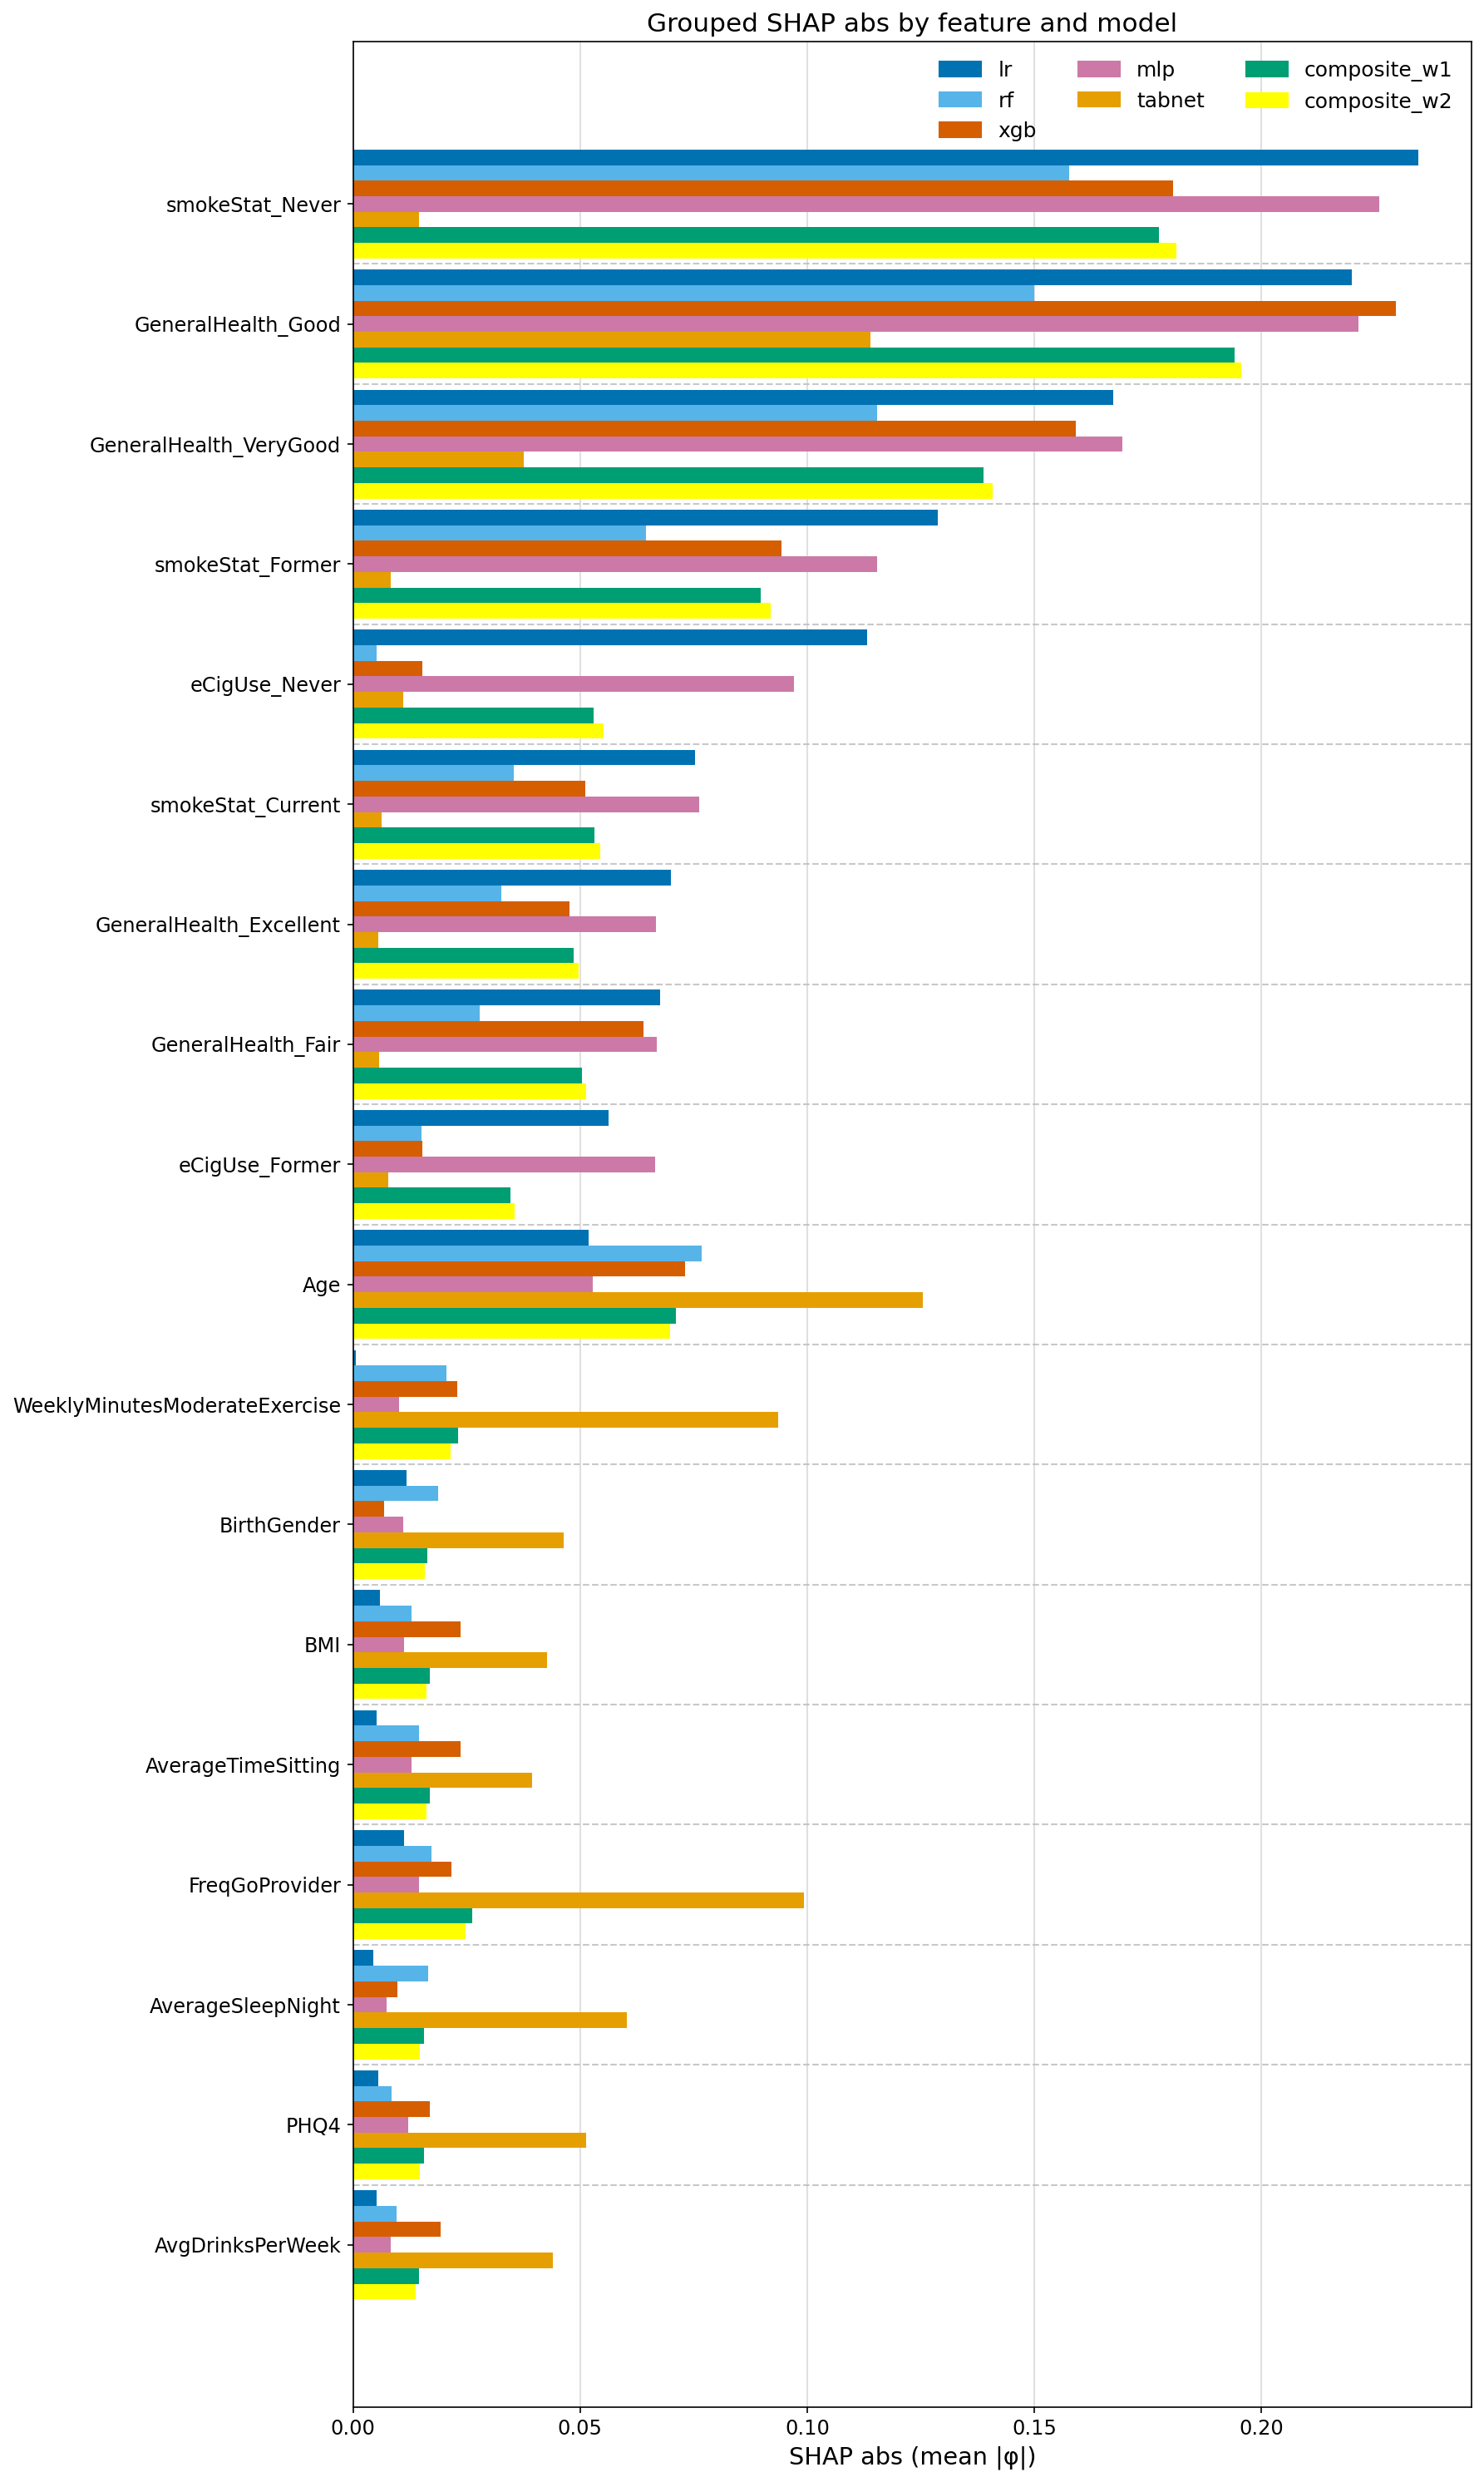

In [69]:
bh, gg, hm = grouped_shap_presets("medium")

models = [m for m in ["lr","rf","xgb","mlp","tabnet","composite_w1", "composite_w2"] if m in imp_mag_kernel]
plot_grouped_barh_shap_abs_thicc(
    imp_mag_dict=imp_mag_permuta,
    models_order=models,
    top_k_per_model=10,
    bar_height=bh, group_gap=gg, height_multiplier=hm,
    legend_fontsize=12, font_scale=1.15,
    fig_width=12, fig_height=20,   # explicit size overrides auto height
    colors=palette,
    draw_separators=True           # keep or toggle separators
)


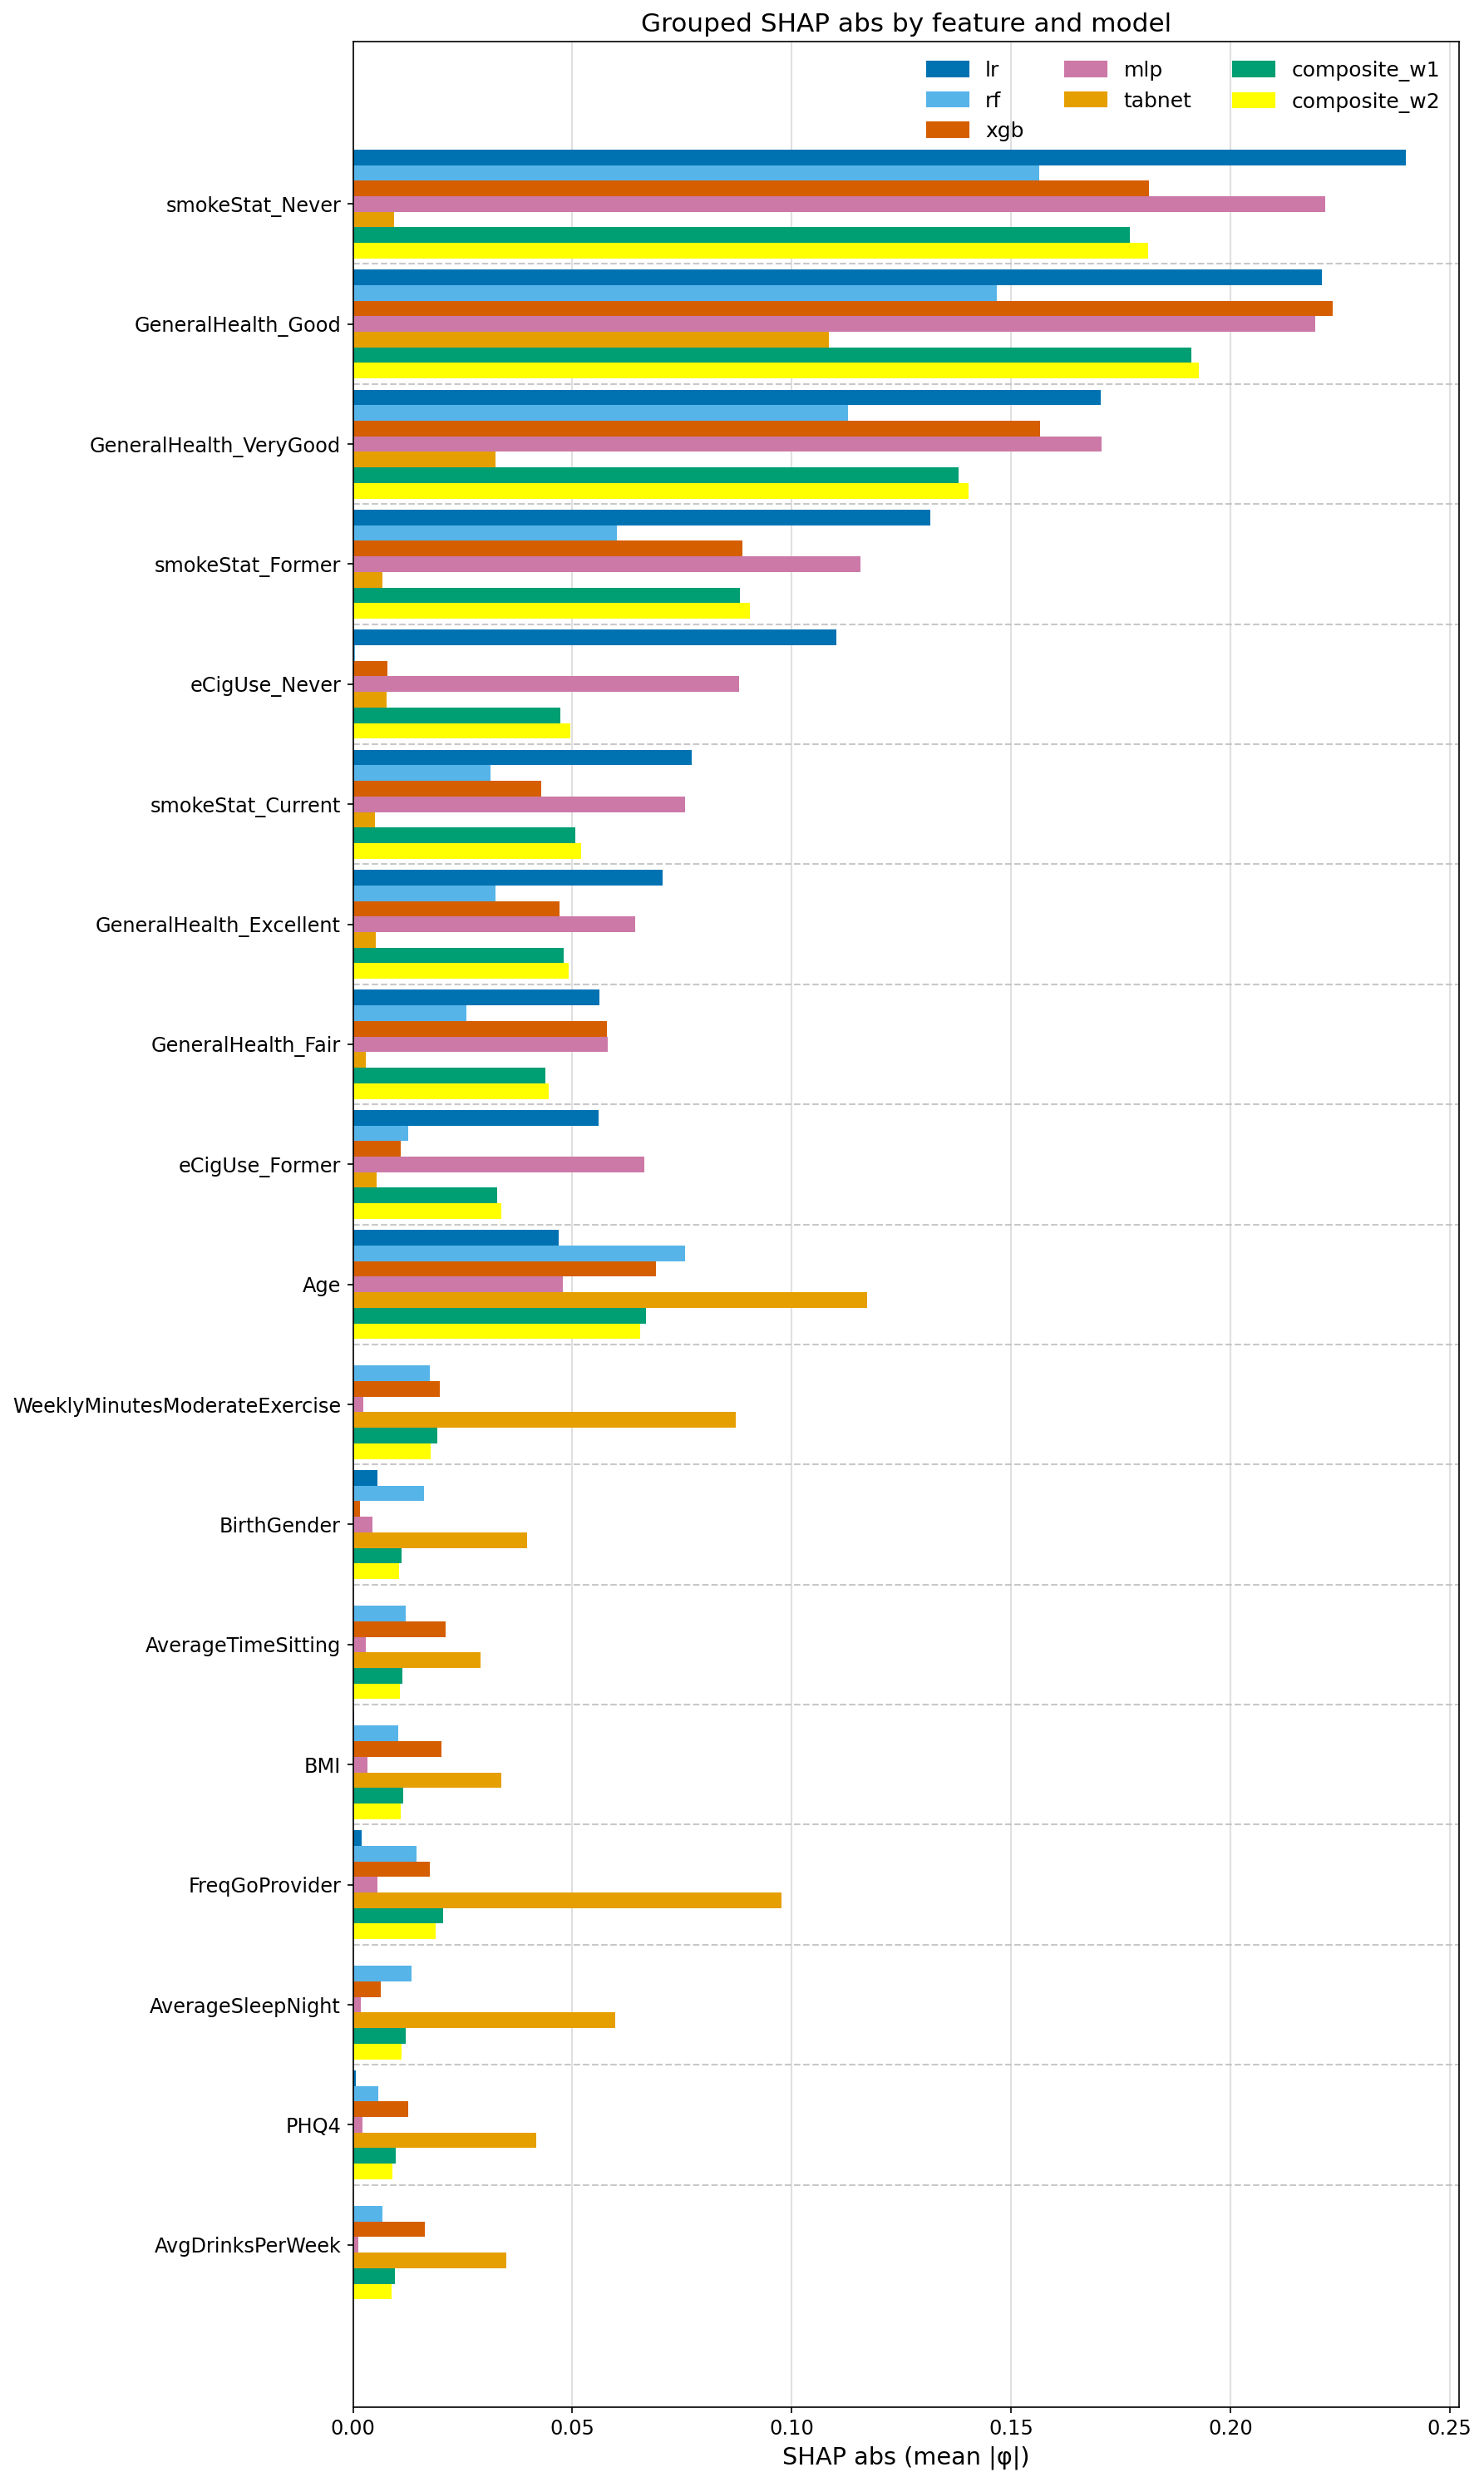

In [70]:
bh, gg, hm = grouped_shap_presets("medium")

models = [m for m in ["lr","rf","xgb","mlp","tabnet","composite_w1", "composite_w2"] if m in imp_mag_kernel]
plot_grouped_barh_shap_abs_thicc(
    imp_mag_dict=imp_mag_kernel,
    models_order=models,
    top_k_per_model=10,
    bar_height=bh, group_gap=gg, height_multiplier=hm,
    legend_fontsize=12, font_scale=1.15,
    fig_width=12, fig_height=20,   # explicit size overrides auto height
    colors=palette,
    draw_separators=True           # keep or toggle separators
)


#### VALIDATION

In [76]:
# ================================
# Local Accuracy (sanity check)
# ================================
import numpy as np, pandas as pd, shap, inspect
from dataclasses import dataclass

RNG = np.random.default_rng(RANDOM_STATE)

# Which input frame to use per model
VAL_BY_MODEL = {
    "lr":     ("scaled",  X_val_scaled,  X_train_res_scaled),
    "mlp":    ("scaled",  X_val_scaled,  X_train_res_scaled),
    "rf":     ("raw",     X_val,         X_train_res),
    "xgb":    ("raw",     X_val,         X_train_res),
    "tabnet": ("raw",     X_val,         X_train_res),
}

def _unwrap(x):
    # unwrap DenseData -> numpy
    return np.asarray(getattr(x, "data", x))

def _perm_explainer_for_model(model, X_bg_np, feature_names=None):
    masker = shap.maskers.Independent(X_bg_np)
    # Try modern API first, then fallbacks (handles SHAP version differences)
    try:
        return shap.Explainer(model.predict_proba, masker, algorithm="permutation")
    except Exception:
        pass
    try:
        return shap.explainers.Permutation(model.predict_proba, masker=masker, feature_names=feature_names)
    except Exception:
        pass
    # very old path
    return shap.PermutationExplainer(model.predict_proba, masker)

@dataclass
class ShapRun:
    values: np.ndarray   # (n_eval, n_feat)
    base:   np.ndarray   # (n_eval,)
    preds:  np.ndarray   # (n_eval,)
    feat_names: list[str]

def _per_instance_perm_shap(model, X_bg_df, X_ev_df, class_index=1, n_bg=32):
    # k-means background on the *model’s* training space
    try:
        bg = shap.kmeans(X_bg_df.values, k=min(n_bg, len(X_bg_df)), random_state=RANDOM_STATE)
    except TypeError:
        bg = shap.kmeans(X_bg_df.values, k=min(n_bg, len(X_bg_df)))
    X_bg_np = _unwrap(bg)

    expl = _perm_explainer_for_model(model, X_bg_np, feature_names=list(X_ev_df.columns))
    sv = expl(X_ev_df.values)  # returns shap.Explanation

    vals = sv.values
    base = sv.base_values
    # normalize to (n, p, c)
    if vals.ndim == 2:
        vals = vals[:, :, None]
        if base.ndim == 1:
            base = base[:, None]
    n, p, c = vals.shape
    cls = 1 if (class_index == "auto" and c == 2) else int(class_index)
    out_vals = vals[:, :, cls]
    out_base = base[:, cls]

    # positive-class probabilities for the same points
    preds = model.predict_proba(X_ev_df.values)[:, cls]
    return ShapRun(values=out_vals, base=out_base, preds=preds, feat_names=list(X_ev_df.columns))

def local_accuracy_summary(residuals_abs: np.ndarray, name: str, ci_z=1.96):
    mae = float(np.mean(residuals_abs))
    std = float(np.std(residuals_abs, ddof=1))
    n = len(residuals_abs)
    se = std / max(np.sqrt(n), 1.0)
    ci_lo, ci_hi = mae - ci_z*se, mae + ci_z*se
    return {"method": name, "n": n, "mae_abs_resid": mae, "ci95_lo": ci_lo, "ci95_hi": ci_hi}

def run_local_accuracy_check(use_models, w, n_eval=128, n_bg=32, class_index="auto"):
    """
    Returns a DataFrame with mean |residual| and 95% CI for:
      - each model vs its own output
      - composite vs weighted ensemble output
    Residual for row i: sum_j φ_{i,j} - (f(x_i) - E[f(X)])
    """
    # pick a common subset of rows (by position) across raw/scaled frames
    n_all = len(X_val)
    n_eval = min(n_eval, n_all)
    idx = RNG.choice(n_all, size=n_eval, replace=False)

    # Compute per-instance SHAP for each model on its proper view of X
    per_model = {}
    preds_store = {}
    base_store = {}
    phi_store = {}

    for m in use_models:
        view, Xv, Xbg = VAL_BY_MODEL[m]
        X_ev = Xv.iloc[idx]
        run = _per_instance_perm_shap(models[m], Xbg, X_ev, class_index=class_index, n_bg=n_bg)
        per_model[m] = run
        phi_store[m] = run.values            # (n_eval, n_feat)
        base_store[m] = run.base             # (n_eval,)
        preds_store[m] = run.preds           # (n_eval,)

    # Align weights to computed models
    cm = [m for m in use_models if m in phi_store and m in w.index]
    if not cm:
        raise ValueError("No overlap between use_models and weight vector indices.")
    wv = w.loc[cm].astype(float)
    wv = wv / wv.sum()

    # Individual model residuals
    rows = []
    for m in cm:
        s = phi_store[m].sum(axis=1)                    # (n_eval,)
        resid = s - (preds_store[m] - base_store[m])    # exact ≈ 0
        rows.append(local_accuracy_summary(np.abs(resid), name=m))

    # Composite SHAP & ensemble residuals
    # composite φ_i,j = sum_m w_m * φ^{(m)}_i,j   (linear)
    # ensemble base   = sum_m w_m * base^{(m)}_i
    # ensemble pred   = sum_m w_m * pred^{(m)}_i
    phi_comp = sum(float(wv[m]) * phi_store[m] for m in cm)                   # (n_eval, n_feat)
    base_ens = sum(float(wv[m]) * base_store[m] for m in cm)                  # (n_eval,)
    pred_ens = sum(float(wv[m]) * preds_store[m] for m in cm)                 # (n_eval,)

    resid_comp = phi_comp.sum(axis=1) - (pred_ens - base_ens)
    rows.append(local_accuracy_summary(np.abs(resid_comp), name=f"composite (weights='{wv.name}' if hasattr(wv,'name') else 'custom')"))

    out = pd.DataFrame(rows).sort_values("mae_abs_resid")
    return out, dict(idx=idx, weights=wv, per_model=per_model)

# ---------- Run it (w1 and/or w2) ----------
la_w1_df, la_w1_debug = run_local_accuracy_check(use_models=use_models, w=w1, n_eval=128, n_bg=32, class_index="auto")
print("\nLocal Accuracy — residual MAE (lower is better) vs ensemble/self (weights = w1):")
display(la_w1_df)

# If you also want to check your second weighting:
if 'w2' in globals():
    la_w2_df, la_w2_debug = run_local_accuracy_check(use_models=use_models, w=w2, n_eval=128, n_bg=32, class_index="auto")
    print("\nLocal Accuracy — residual MAE (lower is better) vs ensemble/self (weights = w2):")
    display(la_w2_df)


PermutationExplainer explainer: 129it [07:47,  3.71s/it]                                                                                                                                                                                     
PermutationExplainer explainer: 129it [00:39,  2.47it/s]                                                                                                                                                                                     


Local Accuracy — residual MAE (lower is better) vs ensemble/self (weights = w1):


,method,n,mae_abs_resid,ci95_lo,ci95_hi
4,tabnet,128,3.114371e-17,2.454939e-17,3.773802e-17
2,xgb,128,4.456071e-17,3.430867e-17,5.481274e-17
1,rf,128,9.410875e-17,8.106213e-17,1.071554e-16
3,mlp,128,9.475927e-17,7.598036e-17,1.135382e-16
0,lr,128,1.099381e-16,9.314628e-17,1.267299e-16
5,"composite (weights='weight' if hasattr(wv,'nam...",128,1.625255e-09,1.380920e-09,1.869590e-09


PermutationExplainer explainer: 129it [07:47,  3.71s/it]                                                                                                                                                                                     
PermutationExplainer explainer: 129it [00:40,  2.41it/s]                                                                                                                                                                                     


Local Accuracy — residual MAE (lower is better) vs ensemble/self (weights = w2):


,method,n,mae_abs_resid,ci95_lo,ci95_hi
4,tabnet,128,3.754050e-17,3.049571e-17,4.458529e-17
2,xgb,128,5.139118e-17,4.071419e-17,6.206818e-17
1,rf,128,9.551821e-17,8.131998e-17,1.097164e-16
3,mlp,128,1.103718e-16,9.036144e-17,1.303821e-16
0,lr,128,1.344411e-16,1.131440e-16,1.557381e-16
5,"composite (weights='weight' if hasattr(wv,'nam...",128,2.055074e-09,1.749538e-09,2.360609e-09


In [77]:
# Compare *each* model's SHAP to the *ensemble* target (same eval set as before)
def mae_ci(x):
    x = np.abs(np.asarray(x)); n=len(x)
    mae=float(x.mean()); se=float(x.std(ddof=1))/max(n**0.5,1); z=1.96
    return mae, mae-z*se, mae+z*se

wv       = la_w1_debug["weights"]
runs     = la_w1_debug["per_model"]
idx      = la_w1_debug["idx"]

# ensemble pieces from the same run
pred_ens = sum(float(wv[m])*runs[m].preds for m in wv.index)
base_ens = sum(float(wv[m])*runs[m].base  for m in wv.index)

rows = []
for m in wv.index:
    s_m   = runs[m].values.sum(axis=1)                 # sum_j φ^{(m)}_i,j
    resid = s_m - (pred_ens - base_ens)                # compare to ensemble target
    mae, lo, hi = mae_ci(resid)
    rows.append({"method": f"{m} vs ENSEMBLE", "mae_abs_resid": mae, "ci95_lo": lo, "ci95_hi": hi})

# composite vs ensemble (should be ~0)
phi_comp = sum(float(wv[m]) * runs[m].values for m in wv.index)
resid_c  = phi_comp.sum(axis=1) - (pred_ens - base_ens)
mae, lo, hi = mae_ci(resid_c)
rows.append({"method": "COMPOSITE vs ENSEMBLE", "mae_abs_resid": mae, "ci95_lo": lo, "ci95_hi": hi})

pd.DataFrame(rows).sort_values("mae_abs_resid")


,method,mae_abs_resid,ci95_lo,ci95_hi
5,COMPOSITE vs ENSEMBLE,1.625255e-09,1.380920e-09,1.869590e-09
0,lr vs ENSEMBLE,5.882419e-02,4.921437e-02,6.843402e-02
1,rf vs ENSEMBLE,6.989248e-02,6.062979e-02,7.915516e-02
3,mlp vs ENSEMBLE,7.277115e-02,6.086130e-02,8.468100e-02
2,xgb vs ENSEMBLE,2.389430e-01,2.254705e-01,2.524155e-01
4,tabnet vs ENSEMBLE,5.346638e-01,4.770832e-01,5.922445e-01


#### MAE ≈ 1.63×10⁻⁹ (lowest → best)
Next best is LR vs ENSEMBLE ≈ 5.88×10⁻², then RF ≈ 6.99×10⁻², MLP ≈ 7.28×10⁻², XGB ≈ 2.39×10⁻¹, TabNet ≈ 5.35×10⁻¹.
Lower residual = closer to perfectly explaining the ensemble. The composite wins because it’s built to explain that target.

##### NOTE: Ensemble is weighted average of each model’s positive-class probability using the weight w1 or w2
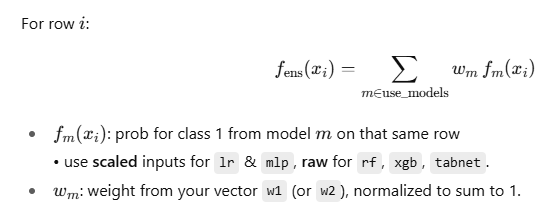
pred_ens = sum(float(wv[m]) * runs[m].preds for m in wv.index)  # ensemble output on eval rows
base_ens = sum(float(wv[m]) * runs[m].base  for m in wv.index)  # ensemble baseline E[f_ens(X)]



,method,mae_abs_resid,ci95_lo,ci95_hi
5,COMPOSITE vs ENSEMBLE,1.625255e-09,1.380920e-09,1.869590e-09
0,lr vs ENSEMBLE,5.882419e-02,4.921437e-02,6.843402e-02
1,rf vs ENSEMBLE,6.989248e-02,6.062979e-02,7.915516e-02
3,mlp vs ENSEMBLE,7.277115e-02,6.086130e-02,8.468100e-02
2,xgb vs ENSEMBLE,2.389430e-01,2.254705e-01,2.524155e-01
4,tabnet vs ENSEMBLE,5.346638e-01,4.770832e-01,5.922445e-01


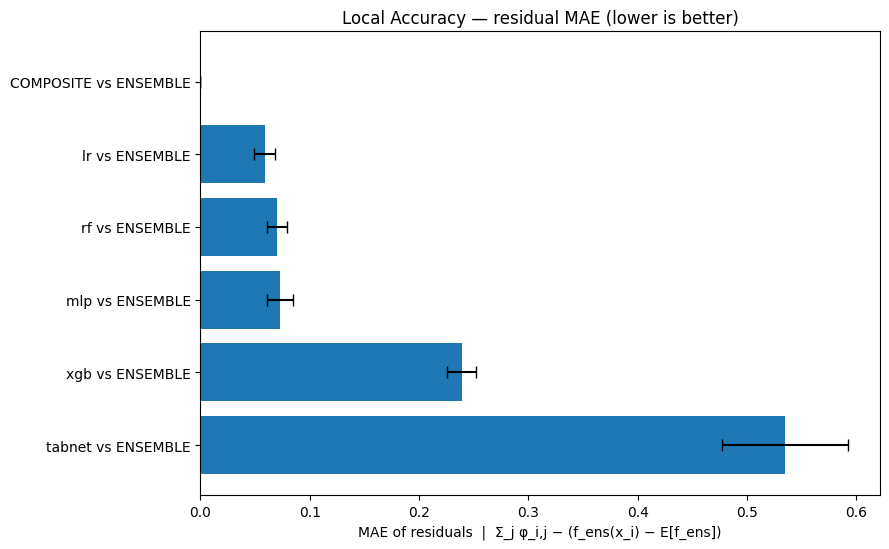

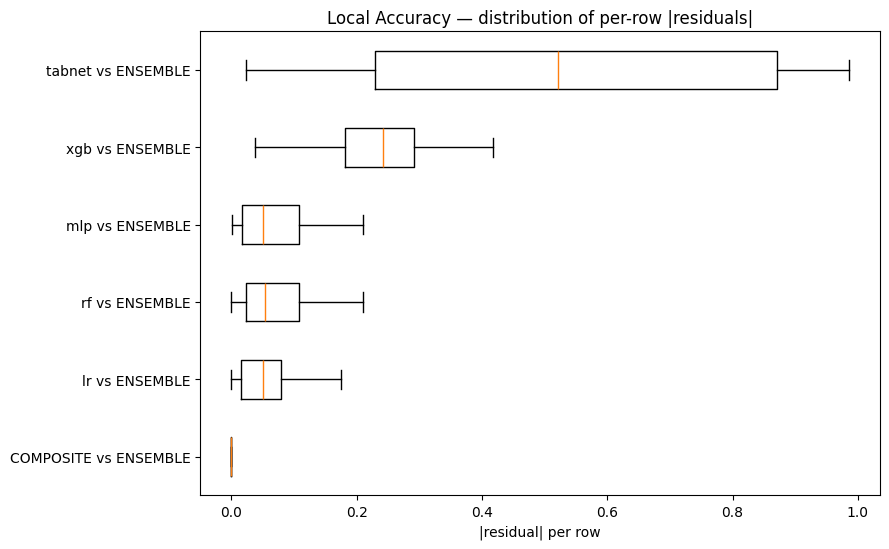

In [79]:
# ============================================
# PLOT: Local-accuracy residuals (MAE + CIs)
# ============================================
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

def mae_ci_vec(x):
    x = np.abs(np.asarray(x)); n=len(x)
    mae=float(x.mean()); se=float(x.std(ddof=1))/max(n**0.5,1); z=1.96
    return mae, mae-z*se, mae+z*se

wv       = la_w1_debug["weights"]
runs     = la_w1_debug["per_model"]
idx      = la_w1_debug["idx"]

# Ensemble pieces from the same eval set
pred_ens = sum(float(wv[m]) * runs[m].preds for m in wv.index)
base_ens = sum(float(wv[m]) * runs[m].base  for m in wv.index)

# Residual vectors per method (compare everyone to ENSEMBLE)
resid_by = {}
for m in wv.index:
    s_m = runs[m].values.sum(axis=1)  # sum_j φ^{(m)}_i,j
    resid_by[f"{m} vs ENSEMBLE"] = s_m - (pred_ens - base_ens)

# Composite residuals
phi_comp = sum(float(wv[m]) * runs[m].values for m in wv.index)
resid_by["COMPOSITE vs ENSEMBLE"] = phi_comp.sum(axis=1) - (pred_ens - base_ens)

# Summary table
rows = []
for name, r in resid_by.items():
    mae, lo, hi = mae_ci_vec(r)
    rows.append({"method": name, "mae_abs_resid": mae, "ci95_lo": lo, "ci95_hi": hi})
df = pd.DataFrame(rows).sort_values("mae_abs_resid")
display(df)

# ---------- Plot 1: MAE with 95% CI (barh)
err_low  = df["mae_abs_resid"] - df["ci95_lo"]
err_high = df["ci95_hi"] - df["mae_abs_resid"]
yerr = np.vstack([err_low.to_numpy(), err_high.to_numpy()])

plt.figure(figsize=(9, 0.6*len(df) + 2))
plt.barh(df["method"], df["mae_abs_resid"], xerr=yerr, capsize=4)
plt.gca().invert_yaxis()
plt.xlabel("MAE of residuals  |  Σ_j φ_i,j − (f_ens(x_i) − E[f_ens])")
plt.title("Local Accuracy — residual MAE (lower is better)")
plt.tight_layout()
plt.show()

# ---------- Plot 2: Per-row absolute residuals (boxplot)
order = df["method"].tolist()
abs_resid_sets = [np.abs(resid_by[m]) for m in order]

plt.figure(figsize=(9, 0.6*len(order) + 2))
plt.boxplot(abs_resid_sets, vert=False, labels=order, showfliers=False)
plt.xlabel("|residual| per row")
plt.title("Local Accuracy — distribution of per-row |residuals|")
plt.tight_layout()
plt.show()


#### 2 Deletion/insertion AUC for ...

In [ ]:
# ============================================================
# Faithfulness via Deletion / Insertion AUC (evaluate on ENSEMBLE)
# ============================================================
import numpy as np, pandas as pd
from numpy.typing import ArrayLike
from typing import Dict, List
from math import ceil

try:
    from scipy.stats import wilcoxon, ttest_rel
except Exception:
    wilcoxon = None
    from math import sqrt

RNG = np.random.default_rng(RANDOM_STATE)

# ---------- helpers
def _ensemble_pred_row(x_raw: pd.Series, x_scaled: pd.Series, weights: pd.Series) -> float:
    """Ensemble prob for a single row using correct views per model."""
    out = 0.0
    for m, w in weights.items():
        if m in ("lr","mlp"):
            z = x_scaled.values.reshape(1, -1)
        else:
            z = x_raw.values.reshape(1, -1)
        out += float(w) * models[m].predict_proba(z)[:, 1][0]
    return float(out)

def _feature_baselines() -> tuple[pd.Series, pd.Series]:
    """Per-feature baselines (means) for raw and scaled spaces."""
    mu_raw    = X_train_res.mean(numeric_only=True)
    mu_scaled = X_train_res_scaled.mean(numeric_only=True)
    # ensure same column order as validation frames
    mu_raw    = mu_raw.reindex(X_val.columns).fillna(0.0)
    mu_scaled = mu_scaled.reindex(X_val_scaled.columns).fillna(0.0)
    return mu_raw, mu_scaled

def _rank_orders(abs_scores: np.ndarray) -> np.ndarray:
    """Descending-importance rank order indices per instance.
       abs_scores: (n, p) -> returns order array (n, p) of feature indices."""
    # argsort ascending, then reverse for descending
    return np.argsort(abs_scores, axis=1)[:, ::-1]

def _auc_trap(y: ArrayLike) -> float:
    """Normalized AUC on k in [0,1] using trapezoids."""
    y = np.asarray(y, float)
    x = np.linspace(0.0, 1.0, num=len(y))
    return float(np.trapz(y, x))

def _mask_progression(x_raw: pd.Series, x_scaled: pd.Series,
                      order: np.ndarray,
                      mu_raw: pd.Series, mu_scaled: pd.Series,
                      step: int = 1) -> tuple[List[float], List[float]]:
    """
    Build deletion (replace top-k by baseline) and insertion (start baseline, add back) curves
    for one instance, using a single feature order (array of feature indices).
    """
    # start states
    x_del_raw    = x_raw.copy()
    x_del_scaled = x_scaled.copy()

    # insertion starts from baselines
    x_ins_raw    = mu_raw.copy()
    x_ins_scaled = mu_scaled.copy()

    # curves include k=0 point
    y_del = [_ensemble_pred_row(x_del_raw, x_del_scaled, wv)]
    y_ins = [_ensemble_pred_row(x_ins_raw, x_ins_scaled, wv)]

    p = len(order)
    for k in range(0, p, step):
        j_slice = order[k:k+step]
        # --- deletion: set top-k features to baseline
        x_del_raw.iloc[j_slice]    = mu_raw.iloc[j_slice].values
        x_del_scaled.iloc[j_slice] = mu_scaled.iloc[j_slice].values
        y_del.append(_ensemble_pred_row(x_del_raw, x_del_scaled, wv))
        # --- insertion: add those features back to original values
        x_ins_raw.iloc[j_slice]    = x_raw.iloc[j_slice].values
        x_ins_scaled.iloc[j_slice] = x_scaled.iloc[j_slice].values
        y_ins.append(_ensemble_pred_row(x_ins_raw, x_ins_scaled, wv))

    return y_del, y_ins

def _pair_test(baseline: np.ndarray, other: np.ndarray, higher_is_better: bool) -> dict:
    """Paired test vs baseline vector (composite)."""
    diff = (other - baseline) if higher_is_better else (baseline - other)
    if wilcoxon is not None:
        try:
            stat, p = wilcoxon(diff, zero_method="wilcox", alternative="greater")
            return {"test":"wilcoxon", "stat": float(stat), "pvalue": float(p)}
        except Exception:
            pass
    # fallback to paired t-test one-sided
    t_stat, p_two = ttest_rel(other, baseline)
    # convert to one-sided "greater"
    from scipy.stats import t
    df = len(baseline) - 1
    # if higher_is_better: H1 = other > baseline
    if higher_is_better:
        p_one = 1 - t.cdf(t_stat, df)
    else:
        p_one = t.cdf(t_stat, df)
    return {"test":"t-test", "stat": float(t_stat), "pvalue": float(p_one)}

# ---------- build inputs from previous local-accuracy run
assert 'la_w1_debug' in globals(), "Run the local-accuracy cell first to create la_w1_debug."
wv = la_w1_debug["weights"]           # normalized weights series
idx = la_w1_debug["idx"]              # eval row indices (into X_val/*)
runs = la_w1_debug["per_model"]       # SHAP runs per model
mu_raw, mu_scaled = _feature_baselines()

# composite per-instance |phi| from the stored per-model outputs
phi_comp = sum(float(wv[m]) * runs[m].values for m in wv.index)      # (n, p)
abs_comp = np.abs(phi_comp)

# and each model's |phi|
abs_per_model = {m: np.abs(runs[m].values) for m in wv.index}

# common settings
n, p = abs_comp.shape
max_points = 50
step = max(1, p // max_points)   # subsample steps to keep curves short

# ---------- compute AUCs
methods = [("composite", abs_comp)] + [(m, abs_per_model[m]) for m in wv.index]
feat_names = list(X_val.columns)

aucs_del: Dict[str, List[float]] = {name: [] for name, _ in methods}
aucs_ins: Dict[str, List[float]] = {name: [] for name, _ in methods}

for r_i in range(n):
    # source rows in both spaces
    x_raw    = X_val.iloc[idx[r_i]].copy()
    x_scaled = X_val_scaled.iloc[idx[r_i]].copy()

    for name, abs_scores in methods:
        order = _rank_orders(abs_scores[r_i:r_i+1, :])[0]  # feature indices sorted desc
        y_del, y_ins = _mask_progression(x_raw, x_scaled, order, mu_raw, mu_scaled, step=step)
        aucs_del[name].append(_auc_trap(y_del))
        aucs_ins[name].append(_auc_trap(y_ins))

# ---------- summarize + paired tests vs composite
def summarize_aucs(aucs_dict: Dict[str, List[float]], higher_is_better: bool) -> pd.DataFrame:
    rows = []
    base = np.asarray(aucs_dict["composite"])
    for name, vals in aucs_dict.items():
        arr = np.asarray(vals)
        mean = float(arr.mean()); std = float(arr.std(ddof=1)); n = len(arr)
        se = std / max(n**0.5, 1.0); z = 1.96
        lo, hi = (mean - z*se, mean + z*se)
        row = {"method": name, "n": n, "mean_auc": mean, "ci95_lo": lo, "ci95_hi": hi}
        if name != "composite":
            row |= _pair_test(base, arr, higher_is_better=higher_is_better)
        rows.append(row)
    df = pd.DataFrame(rows).sort_values("mean_auc", ascending=not higher_is_better)
    return df

del_df = summarize_aucs(aucs_dict=aucs_del, higher_is_better=False)  # lower AUC is better for deletion
ins_df = summarize_aucs(aucs_dict=aucs_ins, higher_is_better=True)   # higher AUC is better for insertion

print("\nDeletion AUC — lower is better (evaluated on ensemble):")
display(del_df)

print("\nInsertion AUC — higher is better (evaluated on ensemble):")
display(ins_df)


##### faster version

In [80]:
# ============================================================
# FAST Deletion / Insertion AUC (batched, top-K, ensemble eval)
# Requires: la_w1_debug from the local-accuracy cell
# ============================================================
import numpy as np, pandas as pd
from scipy.stats import wilcoxon, ttest_rel

rng = np.random.default_rng(RANDOM_STATE)

# ---- knobs to speed up ----
N_ROWS      = 64          # number of eval rows (subset of la_w1_debug["idx"])
TOPK        = 32          # only operate on the top-K features by |phi|
MAX_POINTS  = 25          # max curve points (controls step size)
BACKGROUND  = "mean"      # baseline values; "mean" of train (matches earlier cell)

wv     = la_w1_debug["weights"]     # normalized weights
runs   = la_w1_debug["per_model"]   # SHAP runs per model (contains per-instance phi)
all_id = la_w1_debug["idx"]
take   = min(N_ROWS, len(all_id))
row_ids = list(all_id[:take])

# Baselines (match model domains)
mu_raw    = X_train_res.mean(numeric_only=True).reindex(X_val.columns).fillna(0.0)
mu_scaled = X_train_res_scaled.mean(numeric_only=True).reindex(X_val_scaled.columns).fillna(0.0)

def _auc_trap(y):
    y = np.asarray(y, float); x = np.linspace(0, 1, len(y))
    return float(np.trapz(y, x))

def _pair_test(base, other, higher_is_better):
    base = np.asarray(base); other = np.asarray(other)
    diff = (other - base) if higher_is_better else (base - other)
    try:
        stat, p = wilcoxon(diff, zero_method="wilcox", alternative="greater")
        return {"test":"wilcoxon", "stat": float(stat), "pvalue": float(p)}
    except Exception:
        tstat, p2 = ttest_rel(other, base)
        from scipy.stats import t
        df = len(base)-1
        p1 = 1 - t.cdf(tstat, df) if higher_is_better else t.cdf(tstat, df)
        return {"test":"t-test", "stat": float(tstat), "pvalue": float(p1)}

# ---------- batched ensemble prediction for a batch of points ----------
def _ensemble_pred_batch(X_raw_batch: np.ndarray, X_scaled_batch: np.ndarray) -> np.ndarray:
    """Return ensemble probs for a batch of inputs.
    X_raw_batch, X_scaled_batch: shape (B, P) aligned with X_val columns."""
    out = np.zeros(X_raw_batch.shape[0], dtype=float)
    for m, w in wv.items():
        if m in ("lr","mlp"):
            out += float(w) * models[m].predict_proba(X_scaled_batch)[:, 1]
        else:
            out += float(w) * models[m].predict_proba(X_raw_batch)[:, 1]
    return out

# ---------- build deletion/insertion sequences in batch ----------
def _curves_for_instance(i_row: int, order: np.ndarray, step: int):
    """Return deletion and insertion curves for one row using a single ranking order."""
    x_raw    = X_val.iloc[i_row].to_numpy().copy()
    x_scaled = X_val_scaled.iloc[i_row].to_numpy().copy()
    mu_r     = mu_raw.to_numpy(); mu_s = mu_scaled.to_numpy()

    p = len(order)
    # number of steps (including k=0 and final)
    T = (p + step - 1) // step + 1

    # ----- Deletion batch -----
    Xr_del = np.tile(x_raw,    (T, 1))
    Xs_del = np.tile(x_scaled, (T, 1))
    # progressively set top features to baseline
    for t in range(1, T):
        j_slice = order[: min(t*step, p)]
        Xr_del[t, j_slice] = mu_r[j_slice]
        Xs_del[t, j_slice] = mu_s[j_slice]

    # ----- Insertion batch -----
    Xr_ins = np.tile(mu_r, (T, 1))
    Xs_ins = np.tile(mu_s, (T, 1))
    # add features back
    for t in range(1, T):
        j_slice = order[: min(t*step, p)]
        Xr_ins[t, j_slice] = x_raw[j_slice]
        Xs_ins[t, j_slice] = x_scaled[j_slice]

    y_del = _ensemble_pred_batch(Xr_del, Xs_del)
    y_ins = _ensemble_pred_batch(Xr_ins, Xs_ins)
    return y_del, y_ins

# ---------- ranks (composite + per model), limited to TOPK ----------
abs_comp = sum(float(wv[m]) * np.abs(runs[m].values) for m in wv.index)   # (n, p)
abs_per_model = {m: np.abs(runs[m].values) for m in wv.index}

def _order_topk(row_abs: np.ndarray, topk: int):
    # descending by |phi|, truncated to topk
    order_full = np.argsort(row_abs)[::-1]
    return order_full[:min(topk, len(order_full))]

methods = [("composite", abs_comp)] + [(m, abs_per_model[m]) for m in wv.index]

# curve resolution
P = X_val.shape[1]
step = max(1, (min(TOPK, P)) // max(5, min(MAX_POINTS, TOPK)))  # ~MAX_POINTS steps

# ---------- compute AUCs ----------
aucs_del, aucs_ins = {k: [] for k,_ in methods}, {k: [] for k,_ in methods}

for rid in row_ids:
    # prefetch once per row for speed
    row_abs = {name: arr[all_id.tolist().index(rid)] for name, arr in methods}  # align by position in la run
    for name, _ in methods:
        order = _order_topk(row_abs[name], TOPK)
        # map order to global feature indices already (order is indices)
        y_del, y_ins = _curves_for_instance(rid, order, step=step)
        aucs_del[name].append(_auc_trap(y_del))
        aucs_ins[name].append(_auc_trap(y_ins))

def _summarize(aucs_dict, higher_is_better):
    rows = []
    base = np.asarray(aucs_dict["composite"])
    for name, vals in aucs_dict.items():
        arr = np.asarray(vals, float)
        mean, std = float(arr.mean()), float(arr.std(ddof=1))
        n = len(arr); se = std / max(n**0.5, 1.0); z = 1.96
        lo, hi = mean - z*se, mean + z*se
        row = {"method": name, "n": n, "mean_auc": mean, "ci95_lo": lo, "ci95_hi": hi}
        if name != "composite":
            row |= _pair_test(base, arr, higher_is_better=higher_is_better)
        rows.append(row)
    return pd.DataFrame(rows).sort_values("mean_auc", ascending=not higher_is_better)

del_df = _summarize(aucs_del, higher_is_better=False)   # lower is better
ins_df = _summarize(aucs_ins, higher_is_better=True)    # higher is better

print(f"\nFAST Deletion AUC (K={TOPK}, rows={len(row_ids)}, step={step}) — lower is better:")
display(del_df)

print(f"\nFAST Insertion AUC (K={TOPK}, rows={len(row_ids)}, step={step}) — higher is better:")
display(ins_df)



FAST Deletion AUC (K=32, rows=64, step=1) — lower is better:


,method,n,mean_auc,ci95_lo,ci95_hi,test,stat,pvalue
5,tabnet,64,0.764834,0.744212,0.785455,wilcoxon,2080.0,1.762749e-12
1,lr,64,0.864958,0.858718,0.871199,wilcoxon,1739.0,1.472881e-06
4,mlp,64,0.874623,0.868092,0.881155,wilcoxon,1241.0,8.944373e-02
3,xgb,64,0.876524,0.871818,0.881230,wilcoxon,1204.0,1.363752e-01
0,composite,64,0.877573,0.873710,0.881437,NaN,NaN,NaN
2,rf,64,0.882715,0.878247,0.887183,wilcoxon,516.0,9.997711e-01



FAST Insertion AUC (K=32, rows=64, step=1) — higher is better:


,method,n,mean_auc,ci95_lo,ci95_hi,test,stat,pvalue
5,tabnet,64,0.301395,0.278343,0.324448,wilcoxon,2080.0,1.762749e-12
1,lr,64,0.193743,0.175776,0.211710,wilcoxon,1671.0,1.222512e-05
4,mlp,64,0.186109,0.169644,0.202573,wilcoxon,1622.0,4.968445e-05
2,rf,64,0.173801,0.155849,0.191753,wilcoxon,1183.0,1.694570e-01
0,composite,64,0.172955,0.154908,0.191003,NaN,NaN,NaN
3,xgb,64,0.172164,0.154141,0.190188,wilcoxon,969.0,6.825398e-01


In [81]:
# ----- Extra verification: per-row wins and effect sizes -----
import numpy as np, pandas as pd

def _per_row_auc_lists(aucs_dict):
    # dict[name] -> list per row
    names = list(aucs_dict.keys())
    n = len(next(iter(aucs_dict.values())))
    mats = {k: np.asarray(v) for k,v in aucs_dict.items()}
    return names, n, mats

def _wins_vs_composite(aucs_dict, higher_is_better):
    names, n, mats = _per_row_auc_lists(aucs_dict)
    base = mats["composite"]
    rows = []
    for name in names:
        if name == "composite": continue
        other = mats[name]
        if higher_is_better:
            wins = int(np.sum(base > other))   # composite better on this row
        else:
            wins = int(np.sum(base < other))
        rows.append({"method": name, "rows": n, "composite_wins": wins, "win_rate": wins/n})
    return pd.DataFrame(rows).sort_values("win_rate", ascending=False)

def _cliffs_delta_vs_composite(aucs_dict, higher_is_better):
    # simple Cliff's delta: P(composite better) - P(other better)
    names, n, mats = _per_row_auc_lists(aucs_dict)
    base = mats["composite"]
    rows = []
    for name in names:
        if name == "composite": continue
        other = mats[name]
        if higher_is_better:
            better = np.sum(base > other)
            worse  = np.sum(base < other)
        else:
            better = np.sum(base < other)
            worse  = np.sum(base > other)
        delta = (better - worse) / float(n)
        rows.append({"method": name, "cliffs_delta": float(delta)})
    return pd.DataFrame(rows).sort_values("cliffs_delta", ascending=False)

print("\nDeletion — composite per-row win rates (higher is better for composite):")
display(_wins_vs_composite(aucs_del, higher_is_better=False))
print("Deletion — Cliff's delta vs composite (positive favors composite):")
display(_cliffs_delta_vs_composite(aucs_del, higher_is_better=False))

print("\nInsertion — composite per-row win rates (higher is better for composite):")
display(_wins_vs_composite(aucs_ins, higher_is_better=True))
print("Insertion — Cliff's delta vs composite (positive favors composite):")
display(_cliffs_delta_vs_composite(aucs_ins, higher_is_better=True))



Deletion — composite per-row win rates (higher is better for composite):


,method,rows,composite_wins,win_rate
1,rf,64,44,0.687500
2,xgb,64,29,0.453125
3,mlp,64,27,0.421875
0,lr,64,14,0.218750
4,tabnet,64,0,0.000000


Deletion — Cliff's delta vs composite (positive favors composite):


,method,cliffs_delta
1,rf,0.37500
2,xgb,-0.09375
3,mlp,-0.15625
0,lr,-0.56250
4,tabnet,-1.00000



Insertion — composite per-row win rates (higher is better for composite):


,method,rows,composite_wins,win_rate
2,xgb,64,37,0.578125
1,rf,64,31,0.484375
3,mlp,64,20,0.312500
0,lr,64,17,0.265625
4,tabnet,64,0,0.000000


Insertion — Cliff's delta vs composite (positive favors composite):


,method,cliffs_delta
2,xgb,0.15625
1,rf,-0.03125
3,mlp,-0.37500
0,lr,-0.46875
4,tabnet,-1.00000


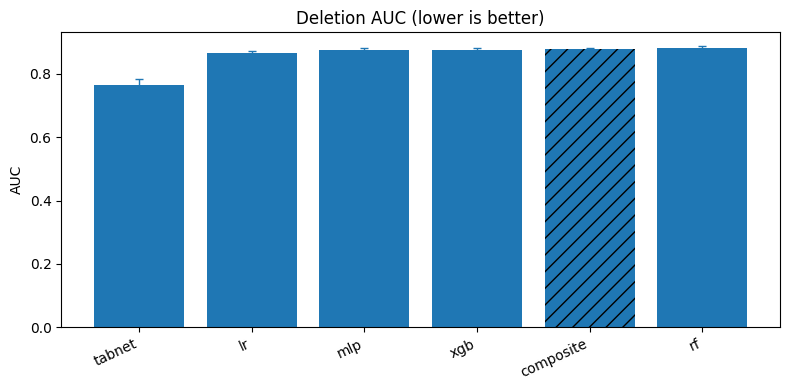

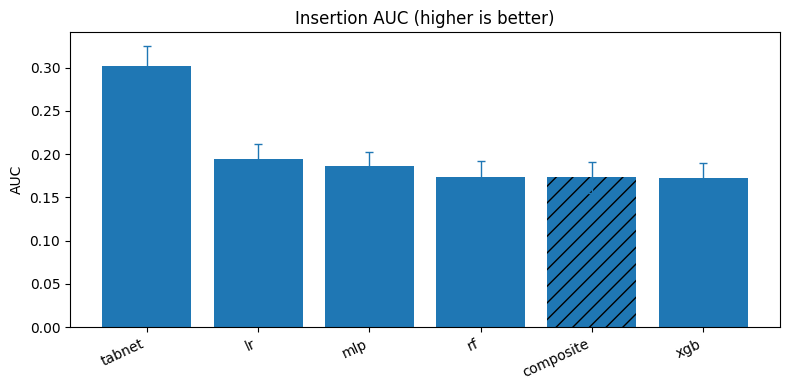

In [82]:
import numpy as np, matplotlib.pyplot as plt

def plot_auc_bars(df, title, higher_is_better):
    dfp = df.copy()
    dfp = dfp.sort_values("mean_auc", ascending=not higher_is_better)
    x = np.arange(len(dfp))
    y = dfp["mean_auc"].to_numpy(float)
    yerr = np.vstack([
        y - dfp["ci95_lo"].to_numpy(float),
        dfp["ci95_hi"].to_numpy(float) - y
    ])

    plt.figure(figsize=(8, 4))
    bars = plt.bar(x, y)
    plt.errorbar(x, y, yerr=yerr, fmt="none", capsize=3, linewidth=1)
    plt.xticks(x, dfp["method"], rotation=25, ha="right")
    plt.ylabel("AUC")
    plt.title(title + (" (higher is better)" if higher_is_better else " (lower is better)"))
    # highlight composite
    for i, name in enumerate(dfp["method"]):
      if name.lower().startswith("composite"):
        bars[i].set_hatch("//")
        bars[i].set_linewidth(1.2)
    plt.tight_layout()
    plt.show()

plot_auc_bars(del_df, "Deletion AUC", higher_is_better=False)
plot_auc_bars(ins_df, "Insertion AUC", higher_is_better=True)


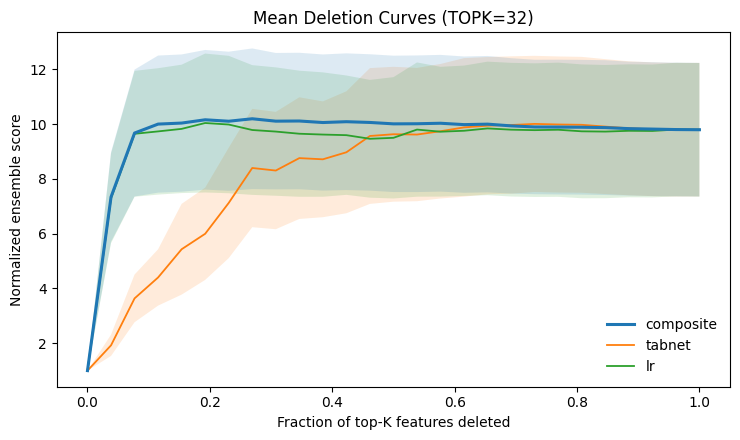

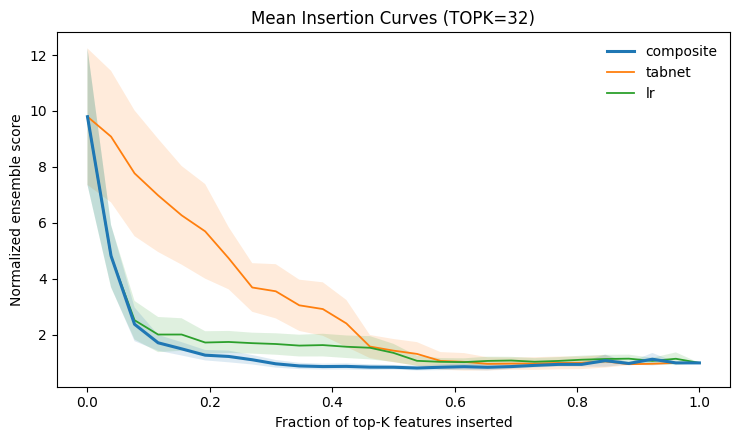

In [83]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt

# pick a few competitors to keep plots readable
def _top_competitors(del_df, ins_df, k=2):
    # exclude composite, pick k best from each table
    d = del_df[~del_df["method"].str.contains("composite", case=False)].nsmallest(k, "mean_auc")["method"].tolist()
    i = ins_df[~ins_df["method"].str.contains("composite", case=False)].nlargest(k, "mean_auc")["method"].tolist()
    return ["composite"] + list(dict.fromkeys(d + i))  # preserve order, unique

methods_to_plot = _top_competitors(del_df, ins_df, k=2)

# utilities from your fast cell
def _ensemble_pred_batch(X_raw_batch: np.ndarray, X_scaled_batch: np.ndarray) -> np.ndarray:
    out = np.zeros(X_raw_batch.shape[0], dtype=float)
    for m, w in wv.items():
        if m in ("lr","mlp"):
            out += float(w) * models[m].predict_proba(X_scaled_batch)[:, 1]
        else:
            out += float(w) * models[m].predict_proba(X_raw_batch)[:, 1]
    return out

def _order_topk_row(abs_row: np.ndarray, topk: int):
    idx = np.argsort(abs_row)[::-1]
    return idx[:min(topk, len(idx))]

def _curves_for_instance(i_row: int, order: np.ndarray, step: int):
    x_raw    = X_val.iloc[i_row].to_numpy().copy()
    x_scaled = X_val_scaled.iloc[i_row].to_numpy().copy()
    mu_r     = mu_raw.to_numpy(); mu_s = mu_scaled.to_numpy()
    p = len(order); T = (p + step - 1) // step + 1

    Xr_del = np.tile(x_raw,    (T, 1)); Xs_del = np.tile(x_scaled, (T, 1))
    Xr_ins = np.tile(mu_r,     (T, 1)); Xs_ins = np.tile(mu_s,     (T, 1))

    for t in range(1, T):
        j = order[: min(t*step, p)]
        Xr_del[t, j] = mu_r[j];   Xs_del[t, j] = mu_s[j]
        Xr_ins[t, j] = x_raw[j];  Xs_ins[t, j] = x_scaled[j]

    y_del = _ensemble_pred_batch(Xr_del, Xs_del)
    y_ins = _ensemble_pred_batch(Xr_ins, Xs_ins)
    return y_del, y_ins

# get per-row |phi| sources prepared earlier
abs_comp = sum(float(wv[m]) * np.abs(runs[m].values) for m in wv.index)
abs_per_model = {m: np.abs(runs[m].values) for m in wv.index}

# mapping from label -> per-row |phi| matrix
name2abs = {"composite": abs_comp}
name2abs.update(abs_per_model)  # adds 'lr','rf','xgb','mlp','tabnet'

# curve resolution consistent with fast AUC cell
P = X_val.shape[1]
step = max(1, (min(TOPK, P)) // max(5, min(MAX_POINTS, TOPK)))
row_ids = list(la_w1_debug["idx"])[:min(len(la_w1_debug["idx"]), 64)]  # same subset as fast cell (adjust if needed)

def _mean_curve_for(name):
    curves_del, curves_ins = [], []
    arr = name2abs[name]
    # get row indices relative to la run ordering
    pos = {rid: i for i, rid in enumerate(la_w1_debug["idx"])}
    for rid in row_ids:
        i = pos[rid]
        order = _order_topk_row(arr[i], TOPK)
        y_del, y_ins = _curves_for_instance(rid, order, step=step)

        # normalize: deletion starts at 1; insertion ends at 1
        y_del = y_del / max(y_del[0], 1e-12)
        y_ins = y_ins / max(y_ins[-1], 1e-12)

        curves_del.append(y_del)
        curves_ins.append(y_ins)

    # pad to equal length if minor length differences occur (shouldn’t with fixed step)
    Ld = min(map(len, curves_del)); Li = min(map(len, curves_ins))
    D = np.vstack([c[:Ld] for c in curves_del])
    I = np.vstack([c[:Li] for c in curves_ins])

    mean_del = D.mean(axis=0); se_del = D.std(axis=0, ddof=1) / max(D.shape[0]**0.5, 1.0)
    mean_ins = I.mean(axis=0); se_ins = I.std(axis=0, ddof=1) / max(I.shape[0]**0.5, 1.0)
    x_del = np.linspace(0, 1, len(mean_del))
    x_ins = np.linspace(0, 1, len(mean_ins))
    return (x_del, mean_del, se_del), (x_ins, mean_ins, se_ins)

# plot
def _plot_curve_panel(methods, title, which="deletion"):
    plt.figure(figsize=(7.5, 4.5))
    for name in methods:
        (x_d, m_d, se_d), (x_i, m_i, se_i) = _mean_curve_for(name)
        if which == "deletion":
            y, se, x = m_d, se_d, x_d
        else:
            y, se, x = m_i, se_i, x_i
        # composite emphasized
        lw = 2.2 if name=="composite" else 1.3
        z  = 4 if name=="composite" else 3
        plt.plot(x, y, label=name, linewidth=lw, zorder=z)
        plt.fill_between(x, y-1.96*se, y+1.96*se, alpha=0.15, zorder=z-1)
    plt.xlabel("Fraction of top-K features" + (" deleted" if which=="deletion" else " inserted"))
    plt.ylabel("Normalized ensemble score")
    plt.title(title)
    plt.legend(frameon=False)
    plt.tight_layout()
    plt.show()

_plot_curve_panel(methods_to_plot, f"Mean Deletion Curves (TOPK={TOPK})", which="deletion")
_plot_curve_panel(methods_to_plot, f"Mean Insertion Curves (TOPK={TOPK})", which="insertion")


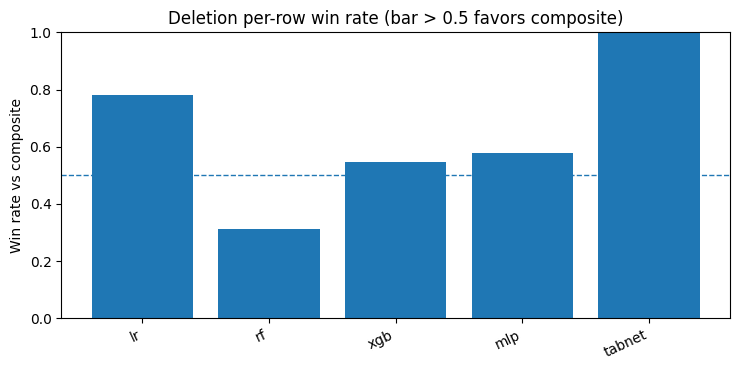

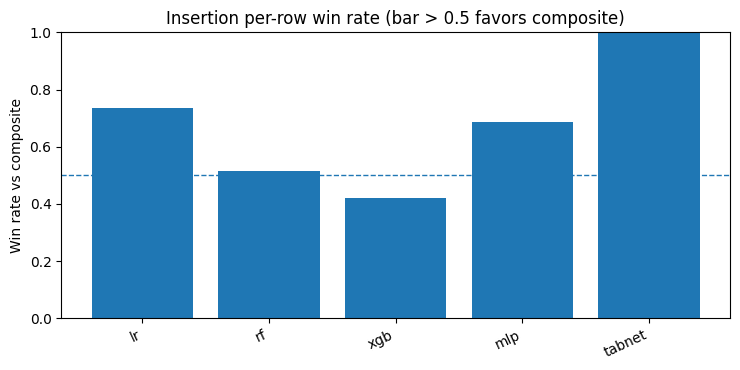

In [84]:
import numpy as np, matplotlib.pyplot as plt

def win_rates(aucs_dict, higher_is_better):
    base = np.asarray(aucs_dict["composite"], float)
    rates = {}
    for name, vals in aucs_dict.items():
        if name == "composite": continue
        v = np.asarray(vals, float)
        wins = np.sum(base < v) if higher_is_better else np.sum(base > v)
        rates[name] = wins / float(len(v))
    return rates

wr_del = win_rates(aucs_del, higher_is_better=False)   # fraction of rows composite has lower AUC
wr_ins = win_rates(aucs_ins, higher_is_better=True)    # fraction of rows composite has higher AUC

def plot_win_rates(wr, title):
    names = list(wr.keys()); vals = [wr[k] for k in names]
    x = np.arange(len(names))
    plt.figure(figsize=(7.5, 3.8))
    plt.bar(x, vals)
    plt.xticks(x, names, rotation=25, ha="right")
    plt.ylim(0, 1)
    plt.axhline(0.5, linestyle="--", linewidth=1)
    plt.ylabel("Win rate vs composite")
    plt.title(title + " (bar > 0.5 favors composite)")
    plt.tight_layout()
    plt.show()

plot_win_rates(wr_del, "Deletion per-row win rate")
plot_win_rates(wr_ins, "Insertion per-row win rate")
